# First Thing - Declare your doubles method and runsize
#### indv: Adjusts all players individually for each match - best if doubles partners don't play together a lot (e.g. tryouts)
#### team: Adjusts teams together and separates them later - best if doubles teams are pretty static (e.g. high school season)

In [1]:
doubles_method='team' # Choose indv or team

In [2]:
runsize=35

### Bring in libraries and CSV files

In [3]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

In [4]:
# Input Files
rating_assumption_loc='C:/Users/toddw/Desktop/Python Rating Code and Files/OSAA_2025_Ratings/position_rating_assumptions.txt'
matchffile_loc='C:/Users/toddw/Desktop/Python Rating Code and Files/OSAA_2025_Ratings/osaa_matches_2025.csv'
players_loc='C:/Users/toddw/Desktop/Python Rating Code and Files/OSAA_2025_Ratings/player_info_girls.csv'
team_match_loc='C:/Users/toddw/Desktop/Python Rating Code and Files/OSAA_2025_Ratings/osaa_team_matches_2025.csv'
school_league_loc='C:/Users/toddw/Desktop/Python Rating Code and Files/OSAA_2025_Ratings/school_league_info.csv'

# Output Files
final_output_csv_loc='C:/Users/toddw/Desktop/Python Rating Code and Files/OSAA_2025_Ratings/OSAA_Ratings_2025.csv'
dynamic_csv_loc='C:/Users/toddw/Desktop/Python Rating Code and Files/OSAA_2025_Ratings/OSAA_2025_Dynamic.csv'

### Supplemental Files to add names, grades and schools for outputs
### Do pre-processing of these first since they have the most unique code

In [5]:
player_supp = pd.read_csv(players_loc, encoding='unicode_escape', header=None, names=['player','school_id','fname','lname','player_name','grade','gender'])

school_supp = pd.read_csv(team_match_loc, encoding='unicode_escape', header=None, skiprows=1, names=['team_match_id','winning_team','losing_team','winning_school',\
                                                              'losing_school','win_cnt','loss_cnt','match_dt','summary'])

league_supp = pd.read_csv(school_league_loc, encoding='unicode_escape', header=None, names=['school_id','school_name','city','state',\
                                                              'class','league','treat_as'])

In [6]:
df_player_supp=player_supp.drop(['fname','lname','gender'],axis=1)
df_school_supp=school_supp.drop(['win_cnt','loss_cnt','match_dt','summary'],axis=1)
df_league_supp=league_supp.drop(['city','state','school_name','treat_as'],axis=1)


print(df_player_supp.head())
print(df_school_supp.head())
print(df_league_supp.head())

   player  school_id      player_name  grade
0   80635      75619    Halle Shearer     12
1   80636      75619   Hannah Millkey     12
2   81005      74665    Sophie Qualls     12
3   81697      75554   Sidrah Schramm     11
4   86378      74631  Default Default     10
   team_match_id  winning_team  losing_team winning_school losing_school
0         197931        124879        74775        Jesuit          Aloha
1         197217       7070582        74775  Mountainside          Aloha
2         196031         75848        74775         Tigard         Aloha
3         195801         74776        74775      Beaverton         Aloha
4         194542         74785        74775     Southridge         Aloha
   school_id class      league
0      74775    6A       Metro
1      74707    1A         SD4
2      74713    5A  Midwestern
3      74728    4A         SD5
4      74776    6A       Metro


In [7]:
df_lista=df_school_supp[['winning_team','winning_school']].rename(columns={'winning_team':'school_id','winning_school':'school_name'})
df_listb=df_school_supp[['losing_team','losing_school']].rename(columns={'losing_team':'school_id','losing_school':'school_name'})
df_school_map_prep=pd.concat([df_lista,df_listb]).drop_duplicates()

df_school_map=df_school_map_prep.merge(df_league_supp, on = 'school_id', how='left')

#df_school_map=pd.DataFrame(df_mf['winning_team'].drop_duplicates())
print("There are ",len(df_school_map)," schools")
df_school_map.head()

There are  124  schools


,school_id,school_name,class,league
0,124879,Jesuit,6A,Metro
1,7070582,Mountainside,6A,Metro
2,75848,Tigard,6A,TRL
3,74776,Beaverton,6A,Metro
4,74785,Southridge,6A,Metro


In [8]:
df_supp_file=df_player_supp.merge(df_school_map, on = 'school_id', how='left')
df_supp_file.drop(['school_id'],axis=1,inplace=True)
df_supp_file.head()

,player,player_name,grade,school_name,class,league
0,80635,Halle Shearer,12,Riverdale,3A,SD1
1,80636,Hannah Millkey,12,Riverdale,3A,SD1
2,81005,Sophie Qualls,12,Ione-Heppner,1A,SD4
3,81697,Sidrah Schramm,11,McDaniel High School,6A,PIL
4,86378,Default Default,10,Century,6A,Pacific


### Pre-processing of main files

In [9]:
df_rating_assumptions = pd.read_csv(rating_assumption_loc, header=None, names=['position','rating'])
df_rating_assumptions.set_index('position',inplace=True)
df_rating_assumptions.head()
base_rating_dict=df_rating_assumptions['rating'].to_dict() #this is only for backup methodology currently

In [10]:
df_matchfile_whole = pd.read_csv(matchffile_loc, encoding='unicode_escape')
#df_matchfile_whole.drop(['Score','School1','School2'],axis=1,inplace=True) # exist in tryout version of code, for no reason
df_matchfile_whole.columns=df_matchfile_whole.columns.str.lower()
df_matchfile_whole[['winner1','winner2','loser1','loser2']]=df_matchfile_whole[['winner1','winner2','loser1','loser2']].apply(pd.to_numeric, errors='coerce').astype('Int64')

df_matchfile_whole.tail(3)

,matchid,match_dt,position,winner1,winner2,loser1,loser2,set1,set2,set3,team_match_id,winner1_name,winner2_name,loser1_name,loser2_name
6402,1279911,4/18/2025,D3,166290,151925,104400,123196,6*2,7*5,0*0,192796,Ariana Barsuglia,Paige Squires,Zuzanna Bownik,Nina Vivek
6403,1279098,4/17/2025,D3,165114,165119,124345,130719,6*4,6*1,0*0,192696,Hannah Hendricks,Vanesa Aguilar-Thompson,Hannah Forrest,Dailey True
6404,1279937,4/18/2025,D1,123656,105485,102463,122724,6*3,1*6,0*0,192696,Kaitlin Carter,Avalon Donnelly,Torah Womack,Alyssa Piquette


#### Create df_mf with just the needed fields for scoring.  df_matchfile_whole can be used later for names

In [11]:
df_mf=df_matchfile_whole.drop(['winner1_name','winner2_name','loser1_name','loser2_name'],axis=1)

## Do a little more field creation to build out the win_level field

#### Get the winner's game count and the loser's game count

In [12]:
#df_mf['set1'].str[:1]+df_mf['set2'].str[:1]+df_mf['set3'].str[:1]
df_mf['winner_games']=df_mf['set1'].str[:1].astype(int)+df_mf['set2'].str[:1].astype(int)+df_mf['set3'].str[:1].astype(int)
df_mf['loser_games']=df_mf['set1'].str[2:3].astype(int)+df_mf['set2'].str[2:3].astype(int)+df_mf['set3'].str[2:3].astype(int)
df_mf

,matchid,match_dt,position,winner1,winner2,loser1,loser2,set1,set2,set3,team_match_id,winner_games,loser_games
0,1323232,2025-05-08,S1,121899,<NA>,164417,<NA>,6*1,6*0,0*0,197931,12,1
1,1323236,2025-05-08,S2,99552,<NA>,123523,<NA>,6*0,6*0,0*0,197931,12,0
2,1323237,2025-05-08,S3,121904,<NA>,123521,<NA>,6*0,6*0,0*0,197931,12,0
3,1323243,2025-05-08,S4,141668,<NA>,123524,<NA>,6*0,6*1,0*0,197931,12,1
4,1317709,2025-05-06,S1,100768,<NA>,164417,<NA>,6*0,6*0,0*0,197217,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6400,1260796,4/9/2025,D2,121172,122443,121173,143733,6*0,5*7,1*0,190631,12,7
6401,1266032,4/11/2025,D4,168688,143732,143591,169128,6*2,6*1,0*0,191314,12,3
6402,1279911,4/18/2025,D3,166290,151925,104400,123196,6*2,7*5,0*0,192796,13,7
6403,1279098,4/17/2025,D3,165114,165119,124345,130719,6*4,6*1,0*0,192696,12,5


In [13]:
df_mf.head()

,matchid,match_dt,position,winner1,winner2,loser1,loser2,set1,set2,set3,team_match_id,winner_games,loser_games
0,1323232,2025-05-08,S1,121899,<NA>,164417,<NA>,6*1,6*0,0*0,197931,12,1
1,1323236,2025-05-08,S2,99552,<NA>,123523,<NA>,6*0,6*0,0*0,197931,12,0
2,1323237,2025-05-08,S3,121904,<NA>,123521,<NA>,6*0,6*0,0*0,197931,12,0
3,1323243,2025-05-08,S4,141668,<NA>,123524,<NA>,6*0,6*1,0*0,197931,12,1
4,1317709,2025-05-06,S1,100768,<NA>,164417,<NA>,6*0,6*0,0*0,197217,12,0


#### Calculate the win level, then reset any values less than 1 to 1, then add it to the df_mf dataframe

In [14]:
win_level_prep=pd.Series(round((12/df_mf['winner_games'])*((df_mf['winner_games']-df_mf['loser_games'])/2),3))
win_level_prep.loc[win_level_prep<1]=1

In [15]:
df_mf['win_level']=win_level_prep

In [16]:
df_mf.head()

,matchid,match_dt,position,winner1,winner2,loser1,loser2,set1,set2,set3,team_match_id,winner_games,loser_games,win_level
0,1323232,2025-05-08,S1,121899,<NA>,164417,<NA>,6*1,6*0,0*0,197931,12,1,5.5
1,1323236,2025-05-08,S2,99552,<NA>,123523,<NA>,6*0,6*0,0*0,197931,12,0,6.0
2,1323237,2025-05-08,S3,121904,<NA>,123521,<NA>,6*0,6*0,0*0,197931,12,0,6.0
3,1323243,2025-05-08,S4,141668,<NA>,123524,<NA>,6*0,6*1,0*0,197931,12,1,5.5
4,1317709,2025-05-06,S1,100768,<NA>,164417,<NA>,6*0,6*0,0*0,197217,12,0,6.0


In [17]:
#df_test = pd.crosstab([df_mf['winner_games'],df_mf['loser_games']], df_mf['win_level'].round(0)) #from build audit
#df_test.head(20)

<function matplotlib.pyplot.show(close=None, block=None)>

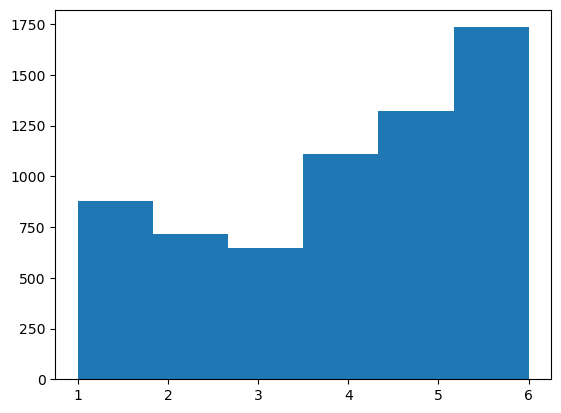

In [18]:
plt.hist(df_mf['win_level'],6)
plt.show

## Start Beginning Rating Creation: Merge the rating assumptions with the matches

In [19]:
df_add_start_ratings=df_mf.merge(df_rating_assumptions, on = 'position', how='left')
df_add_start_ratings.tail()
# Could also be done like this, but you'll have to monitor the assignment of base_rating_dict
#df_add_start_ratings99=df_mf
#df_add_start_ratings99['rating']=df_add_start_ratings99['position'].map(base_rating_dict)
#df_add_start_ratings99.tail()

,matchid,match_dt,position,winner1,winner2,loser1,loser2,set1,set2,set3,team_match_id,winner_games,loser_games,win_level,rating
6400,1260796,4/9/2025,D2,121172,122443,121173,143733,6*0,5*7,1*0,190631,12,7,2.500,20.1
6401,1266032,4/11/2025,D4,168688,143732,143591,169128,6*2,6*1,0*0,191314,12,3,4.500,17.0
6402,1279911,4/18/2025,D3,166290,151925,104400,123196,6*2,7*5,0*0,192796,13,7,2.769,18.5
6403,1279098,4/17/2025,D3,165114,165119,124345,130719,6*4,6*1,0*0,192696,12,5,3.500,18.5
6404,1279937,4/18/2025,D1,123656,105485,102463,122724,6*3,1*6,0*0,192696,7,9,1.000,23.2


In [20]:
nan_count = df_add_start_ratings.isna().sum()
print(nan_count)

matchid             0
match_dt            0
position            0
winner1             0
winner2          3160
loser1              0
loser2           3160
set1                0
set2                0
set3                0
team_match_id       0
winner_games        0
loser_games         0
win_level           0
rating              7
dtype: int64


### Create list of players and their match ratings to average for their start rating

In [21]:
df_win1=df_add_start_ratings[['winner1','rating']].rename(columns={'winner1':'player'})
df_win2=df_add_start_ratings[['winner2','rating']].rename(columns={'winner2':'player'})
df_lose1=df_add_start_ratings[['loser1','rating']].rename(columns={'loser1':'player'})
df_lose2=df_add_start_ratings[['loser2','rating']].rename(columns={'loser2':'player'})
df_start_ratings=pd.concat([df_win1,df_win2,df_lose1,df_lose2])
print("There are ",len(df_start_ratings)," rows")

There are  25620  rows


In [22]:
# There are nulls from winner2 and loser2 in singles matches - drop those
df_start_ratings.dropna(axis=0,inplace=True)
print("There are ",len(df_start_ratings)," rows after null removal (should be about 25% less)")

There are  19272  rows after null removal (should be about 25% less)


### Create df_sr with the average assumed rating per match to get the players starting rating

# Using .reset_index keeps player as a column instead of an index
# Determine later whether that is better or not

In [23]:
df_sr=df_start_ratings.groupby(['player']).mean('rating')
df_sr.to_csv('C:/Users/toddw/Desktop/Python Rating Code and Files/OSAA_2025_Ratings/temp_file_for_research.csv')

In [24]:
print(len(df_sr))
print(df_sr.head())

2193
           rating
player           
80635   23.366667
80636   22.785714
81005   23.400000
98157   22.660000
98158   27.000000


#### Check on 1 player (from the list above) match list to confirm the average looks right - looking for an average of 21.6

In [25]:
df_start_ratings.loc[df_start_ratings.player==74712]

,player,rating


In [26]:
df_start_ratings.head()

,player,rating
0,121899,27.0
1,99552,23.4
2,121904,21.0
3,141668,19.5
4,100768,27.0


<function matplotlib.pyplot.show(close=None, block=None)>

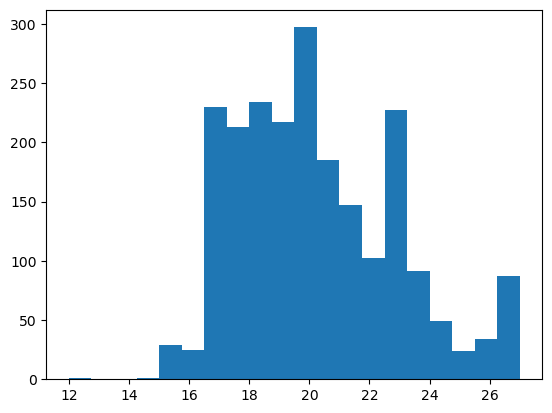

In [27]:
plt.hist(df_sr['rating'],20)
plt.show

### put the start ratings into a re-used dataframe called df_base_rating

In [28]:
df_base_rating = pd.DataFrame(df_sr.rating)
df_base_rating.head()

,rating
player,
80635,23.366667
80636,22.785714
81005,23.400000
98157,22.660000
98158,27.000000


In [29]:
# For doubles matches only, concatenate the two player ids with the lower one always being first
# Add the winning team and losing team columns to the match file (df_mf)
doubles_only=df_mf['position'].str[0]=='D'
df_mf.loc[doubles_only,'winning_team'] = df_mf.apply(lambda row: '/'.join(sorted([str(row['winner1']), str(row['winner2'])])), axis=1)
df_mf.loc[doubles_only,'losing_team'] = df_mf.apply(lambda row: '/'.join(sorted([str(row['loser1']), str(row['loser2'])])), axis=1)


In [30]:
df_mf.tail()

,matchid,match_dt,position,winner1,winner2,loser1,loser2,set1,set2,set3,team_match_id,winner_games,loser_games,win_level,winning_team,losing_team
6400,1260796,4/9/2025,D2,121172,122443,121173,143733,6*0,5*7,1*0,190631,12,7,2.500,121172/122443,121173/143733
6401,1266032,4/11/2025,D4,168688,143732,143591,169128,6*2,6*1,0*0,191314,12,3,4.500,143732/168688,143591/169128
6402,1279911,4/18/2025,D3,166290,151925,104400,123196,6*2,7*5,0*0,192796,13,7,2.769,151925/166290,104400/123196
6403,1279098,4/17/2025,D3,165114,165119,124345,130719,6*4,6*1,0*0,192696,12,5,3.500,165114/165119,124345/130719
6404,1279937,4/18/2025,D1,123656,105485,102463,122724,6*3,1*6,0*0,192696,7,9,1.000,105485/123656,102463/122724


## Create the starting ratings for doubles teams

#### First, create the unique list of teams with player1 and player2 fields

In [31]:
df_unique_winning_teams=pd.DataFrame(df_mf['winning_team'].drop_duplicates())
df_unique_losing_teams=pd.DataFrame(df_mf['losing_team'].drop_duplicates())

df_teams=pd.concat([df_unique_winning_teams.rename(columns={'winning_team': 'team'})\
                   ,df_unique_losing_teams.rename(columns={'losing_team': 'team'})])
df_teams=df_teams.dropna()
df_teams=df_teams.drop_duplicates()
print('Unique Team Count')
print(df_teams.nunique())
print('Confirm the record count below matches the unique count above')
print(df_teams.shape)
df_teams['player1']=df_teams['team'].str.split('/', n=1).str[0].astype(int)
df_teams['player2']=df_teams['team'].str.split('/', n=1).str[1].astype(int)

Unique Team Count
team    2023
dtype: int64
Confirm the record count below matches the unique count above
(2023, 1)


#### Now pull in the players ratings and average them to get the starting rating for the team

In [32]:
#df_add_start_ratings=df_mf.merge(df_rating_assumptions, on = 'position', how='left')
#df_add_start_ratings.head()
df_temp1=df_teams.merge(df_base_rating, left_on = 'player1', right_on='player', how='left')\
                 .merge(df_base_rating, left_on = 'player2', right_on='player', how='left')

df_temp1['rating']=round((df_temp1['rating_x']+df_temp1['rating_y'])/2,3)

df_base_per_team=df_temp1.drop(['player1','player2','rating_x','rating_y'],axis=1).set_index('team')
df_base_per_team.head()

,rating
team,
121901/99666,23.219
141666/141667,18.988
121903/99667,17.703
141669/164691,17.150
100765/164250,21.004


<function matplotlib.pyplot.show(close=None, block=None)>

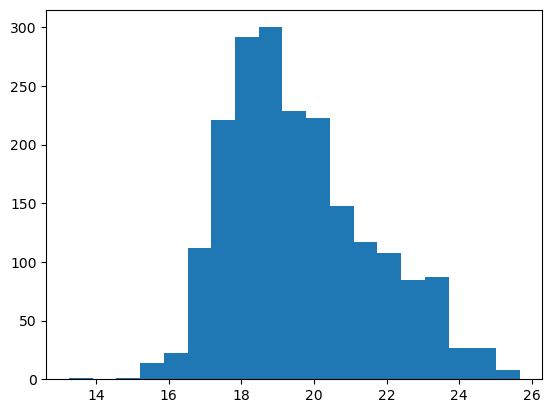

In [33]:
plt.hist(df_base_per_team['rating'],19)
plt.show

# Function Definition (Singles, Doubles (solo), Doubles (team))

In [34]:
#### These functions create match-specific dynamic ratings for each player
#### The dynamic rating essentially:
####   1. Finds the average rating of the players involved
####   2. Adds half the win-level to the winner and subtracts half from the loser
####      So, if a 26 beats a 20 with a win-level of 2, they get dynamic ratings of 24 and 22 (avg = 23)
####
####  For Doubles (solo), the same concept happens with all four players treated independently
####  For Doubles (team):
####    a. Teams are rated as a team (using singles-like methodology)
####    b. But teammates are then compared to each other based on play with other partners
####    c. If a team is rated 25
####       i. But player A is part of teams rated 27 with other partners
####       ii. And player B is part of teams rated 21 with other partners
####       iii. Those are factored in (with weighting) to rate them as 28 / 22
####       iv. Then the players have their rating with each partner combined

### Singles Scoring Function

In [35]:
# This singles function is re-usable
# This sing_score df starts with a copy of the singles results each pass
#   but it gets the start ratings from a rating file that updates with each loop
def compute_singles_ratings():
    df_sing_score=df_mf[df_mf['position'].str.startswith('S')]
    df_sing_score=df_sing_score.merge(df_base_rating, left_on = 'winner1', right_index=True, how='left')\
                               .merge(df_base_rating, left_on = 'loser1', right_index=True, how='left')
    df_sing_score=df_sing_score.rename(columns={'rating_x':'winner1start'})
    df_sing_score=df_sing_score.rename(columns={'rating_y':'loser1start'})
    df_sing_score['runsize']=runsize
    df_sing_score['run']=run

    condition = (df_sing_score['winner1start'] - df_sing_score['loser1start'] > 6) & (df_sing_score['win_level'] >= 4.5)
    df_sing_score.loc[condition, 'winner1enddyn'] = df_sing_score['winner1start']
    df_sing_score.loc[condition, 'loser1enddyn'] = df_sing_score['loser1start']
    df_sing_score.loc[condition, 'scoring'] = "Unscored"
    df_sing_score.loc[condition, 'processed'] = "Yes"
    df_sing_score.loc[condition, 'step'] = 1

    df_sing_score.loc[~condition, 'factor'] = 0  # Initialize 'factor' column

    condition2 = (df_sing_score['runsize'] > 3) & (df_sing_score['run'] < 3) & (df_sing_score['processed'].isnull())
    df_sing_score.loc[condition2, 'factor'] = (df_sing_score['win_level'] - (df_sing_score['winner1start'] - df_sing_score['loser1start'])) / 8
    df_sing_score.loc[condition2, 'processed'] = "Yes"
    df_sing_score.loc[condition2, 'step'] = 2

    condition3 = (df_sing_score['runsize'] > 5) & (df_sing_score['run'] < 5) & (df_sing_score['processed'].isnull())
    df_sing_score.loc[condition3, 'factor'] = (df_sing_score['win_level'] - (df_sing_score['winner1start'] - df_sing_score['loser1start'])) / 4
    df_sing_score.loc[condition3, 'processed'] = "Yes"
    df_sing_score.loc[condition3, 'step'] = 3

    condition4 = (df_sing_score['processed'].isnull())
    df_sing_score.loc[condition4, 'factor'] = (df_sing_score['win_level'] - (df_sing_score['winner1start'] - df_sing_score['loser1start'])) / 2
    df_sing_score.loc[condition4, 'processed'] = "Yes"
    df_sing_score.loc[condition4, 'step'] = 4

    condition5 = (df_sing_score['scoring'].isnull())
    df_sing_score.loc[condition5,'winner1enddyn'] = df_sing_score['winner1start'] + df_sing_score['factor']
    df_sing_score.loc[condition5,'loser1enddyn'] = df_sing_score['loser1start'] - df_sing_score['factor']
    df_sing_score.loc[condition5, 'scoring'] = "Scored"


    # Drop intermediate columns if needed
    df_sing_score = df_sing_score.drop(['factor'], axis=1)
    
    return df_sing_score

### Doubles (solo) Scoring Function

In [36]:
# This doubles function is re-usable
# This doub_score df starts with a copy of the doubles results each pass
#   but it gets the start ratings from a rating file that updates with each loop
#   This version (solo) is for situations where teams rarely play together (eg. tryouts)
#   The team version will be for situations where teams play together frequently during a year

def compute_doubles_ratings_indv():
    df_doub_score=df_mf[df_mf['position'].str.startswith('D')]
    df_doub_score_w=df_doub_score.merge(df_base_rating, left_on = 'winner1', right_index=True, how='left', suffixes=('_winner1', '_winner2'))\
                           .merge(df_base_rating, left_on = 'winner2', right_index=True, how='left', suffixes=('_winner1', '_winner2'))
    df_doub_score_l=df_doub_score.merge(df_base_rating, left_on = 'loser1', right_index=True, how='left', suffixes=('_loser1', '_loser2'))\
                           .merge(df_base_rating, left_on = 'loser2', right_index=True, how='left', suffixes=('_loser1', '_loser2'))

    df_doub_score_l2=df_doub_score_l.drop(['match_dt','position','winner1','winner2','loser1','loser2','set1','set2','set3'\
                        ,'team_match_id','winner_games','loser_games','win_level','winning_team','losing_team'],axis=1)

    df_doub_score=df_doub_score_w.merge(df_doub_score_l2, left_on = 'matchid', right_on = 'matchid', how='left')

    df_doub_score=df_doub_score.rename(columns={'rating_winner1':'winner1start'})
    df_doub_score=df_doub_score.rename(columns={'rating_winner2':'winner2start'})
    df_doub_score=df_doub_score.rename(columns={'rating_loser1':'loser1start'})
    df_doub_score=df_doub_score.rename(columns={'rating_loser2':'loser2start'})

    df_doub_score['winteamstart']=(df_doub_score['winner1start']+df_doub_score['winner2start'])/2
    df_doub_score['loseteamstart']=(df_doub_score['loser1start']+df_doub_score['loser2start'])/2

    df_doub_score['runsize']=runsize
    df_doub_score['run']=run

    condition = (df_doub_score['winteamstart'] - df_doub_score['loseteamstart'] > 6) & (df_doub_score['win_level'] >= 4.5)
    #df_doub_score.loc[condition, 'winner1enddyn'] = df_doub_score['winner1start']
    #df_doub_score.loc[condition, 'winner2enddyn'] = df_doub_score['winner2start']
    #df_doub_score.loc[condition, 'loser1enddyn'] = df_doub_score['loser1start']
    #df_doub_score.loc[condition, 'loser2enddyn'] = df_doub_score['loser2start']
    df_doub_score.loc[condition, 'factor'] = 0
    df_doub_score.loc[condition, 'scoring'] = "Unscored"
    df_doub_score.loc[condition, 'processed'] = "Yes"
    df_doub_score.loc[condition, 'step'] = 1

    df_doub_score.loc[~condition, 'factor'] = 0  # Initialize 'factor' column

    condition2 = (df_doub_score['runsize'] > 3) & (df_doub_score['run'] < 3) & (df_doub_score['processed'].isnull())
    df_doub_score.loc[condition2, 'factor'] = (df_doub_score['win_level'] - (df_doub_score['winteamstart'] - df_doub_score['loseteamstart'])) / 8
    df_doub_score.loc[condition2, 'processed'] = "Yes"
    df_doub_score.loc[condition2, 'step'] = 2

    condition3 = (df_doub_score['runsize'] > 5) & (df_doub_score['run'] < 5) & (df_doub_score['processed'].isnull())
    df_doub_score.loc[condition3, 'factor'] = (df_doub_score['win_level'] - (df_doub_score['winteamstart'] - df_doub_score['loseteamstart'])) / 4
    df_doub_score.loc[condition3, 'processed'] = "Yes"
    df_doub_score.loc[condition3, 'step'] = 3

    condition4 = (df_doub_score['processed'].isnull())
    df_doub_score.loc[condition4, 'factor'] = (df_doub_score['win_level'] - (df_doub_score['winteamstart'] - df_doub_score['loseteamstart'])) / 2
    df_doub_score.loc[condition4, 'processed'] = "Yes"
    df_doub_score.loc[condition4, 'step'] = 4

    condition5 = (df_doub_score['scoring'].isnull())
    df_doub_score.loc[condition5, 'scoring'] = "Scored"

    df_doub_score['winner1enddyn'] = df_doub_score['winner1start'] + df_doub_score['factor']
    df_doub_score['winner2enddyn'] = df_doub_score['winner2start'] + df_doub_score['factor']
    df_doub_score['loser1enddyn'] = df_doub_score['loser1start'] - df_doub_score['factor']
    df_doub_score['loser2enddyn'] = df_doub_score['loser2start'] - df_doub_score['factor']


    # Drop intermediate columns if needed
    df_doub_score = df_doub_score.drop(['factor'], axis=1)
    
    return df_doub_score

### Doubles (team) Scoring Function

In [37]:
# This team_score df starts with a copy of the teamles results each pass
#   but it gets the start ratings from a rating file that updates with each loop
def compute_doubles_team_ratings():
    df_team_score=df_mf[df_mf['position'].str.startswith('D')]
    df_team_score=df_team_score.merge(df_base_rating, left_on = 'winning_team', right_index=True, how='left')\
                               .merge(df_base_rating, left_on = 'losing_team', right_index=True, how='left')
    df_team_score=df_team_score.rename(columns={'rating_x':'winning_teamstart'})
    df_team_score=df_team_score.rename(columns={'rating_y':'losing_teamstart'})
    df_team_score['runsize']=runsize
    df_team_score['run']=run

    condition = (df_team_score['winning_teamstart'] - df_team_score['losing_teamstart'] > 6) & (df_team_score['win_level'] >= 4.5)
    df_team_score.loc[condition, 'winning_teamenddyn'] = df_team_score['winning_teamstart']
    df_team_score.loc[condition, 'losing_teamenddyn'] = df_team_score['losing_teamstart']
    df_team_score.loc[condition, 'scoring'] = "Unscored"
    df_team_score.loc[condition, 'processed'] = "Yes"
    df_team_score.loc[condition, 'step'] = 1

    df_team_score.loc[~condition, 'factor'] = 0  # Initialize 'factor' column

    condition2 = (df_team_score['runsize'] > 3) & (df_team_score['run'] < 3) & (df_team_score['processed'].isnull())
    df_team_score.loc[condition2, 'factor'] = (df_team_score['win_level'] - (df_team_score['winning_teamstart'] - df_team_score['losing_teamstart'])) / 8
    df_team_score.loc[condition2, 'processed'] = "Yes"
    df_team_score.loc[condition2, 'step'] = 2

    condition3 = (df_team_score['runsize'] > 5) & (df_team_score['run'] < 5) & (df_team_score['processed'].isnull())
    df_team_score.loc[condition3, 'factor'] = (df_team_score['win_level'] - (df_team_score['winning_teamstart'] - df_team_score['losing_teamstart'])) / 4
    df_team_score.loc[condition3, 'processed'] = "Yes"
    df_team_score.loc[condition3, 'step'] = 3

    condition4 = (df_team_score['processed'].isnull())
    df_team_score.loc[condition4, 'factor'] = (df_team_score['win_level'] - (df_team_score['winning_teamstart'] - df_team_score['losing_teamstart'])) / 2
    df_team_score.loc[condition4, 'processed'] = "Yes"
    df_team_score.loc[condition4, 'step'] = 4

    condition5 = (df_team_score['scoring'].isnull())
    df_team_score.loc[condition5,'winning_teamenddyn'] = df_team_score['winning_teamstart'] + df_team_score['factor']
    df_team_score.loc[condition5,'losing_teamenddyn'] = df_team_score['losing_teamstart'] - df_team_score['factor']
    df_team_score.loc[condition5, 'scoring'] = "Scored"


    # Drop intermediate columns if needed
    df_team_score = df_team_score.drop(['factor'], axis=1)
    
    return df_team_score

In [38]:
print(df_base_rating.head())

           rating
player           
80635   23.366667
80636   22.785714
81005   23.400000
98157   22.660000
98158   27.000000


## SQL Code to break team-only ratings into individual player ratings

In [39]:
sql_csv='C:/Users/toddw/Desktop/Python Rating Code and Files/OSAA_2025_Ratings/final_doub_player_ratings.csv'

In [40]:
def doubles_team_rescore():    
    #Connecting to sqlite
    conn = sqlite3.connect('doubles_rescore.db')

    #Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    cursor.execute("DROP TABLE IF EXISTS doub_rating_output")

    #Creating table as per requirement
    sql ='''CREATE TABLE doub_rating_output(
       Team TEXT,
       DynamicRating REAL,
       MatchCount INTEGER
    )'''
    cursor.execute(sql)
    conn.commit()

    cursor.executemany('INSERT INTO doub_rating_output VALUES(?,?,?);',newratelist);
    print('We have moved', cursor.rowcount, 'records from Python to SQLite for Doubles Calculations.')

    cursor.execute("drop table if exists parsed")
    sql='''create table parsed as
    select *
    from
    (select team, DynamicRating, MatchCount, substr(team,1,instr(team,"/")-1) as PlayerA, substr(team,instr(team,"/")+1,length(team)-instr(team,"/")) as Partner
    from doub_rating_output
    where team<>'Team'
    union ALL
    select team, DynamicRating, MatchCount, substr(team,instr(team,"/")+1,length(team)-instr(team,"/")) as PlayerA, substr(team,1,instr(team,"/")-1) as Partner
    from doub_rating_output
    where team<>'Team'
    )'''
    cursor.execute(sql)
    conn.commit()

    cursor.execute("drop table if exists partnerships")
    sql='''create table partnerships as
    select distinct PlayerA, partner, DynamicRating as rating_together, matchcount as matches_together
    from parsed
    '''
    cursor.execute(sql)
    conn.commit()

    cursor.execute("drop table if exists dyn_without")
    sql='''create table dyn_without as
    select a.playerA, a.partner, a.rating_together, a.matches_together, sum(matchcount) as matches_without, ifnull((sum(matchcount*dynamicrating)/sum(matchcount)),rating_together) as avg_rating_without_partner
    from partnerships a
      left JOIN
         parsed b
      on a.PlayerA=b.PlayerA and a.partner<>b.Partner
    group by 1,2,3,4
    order by 1,2,3,4
    '''
    cursor.execute(sql)
    conn.commit()


    cursor.execute("drop table if exists new_rating_calcs")
    sql='''create table new_rating_calcs as
    select PlayerA, Partner, sum(matches_together) as matches, sum(matches_together*(rating_together+0.5*(rating_together-avg_rating_without_partner)))/sum(matches_together) as Partner_New_Rating
    from dyn_without
    group by 1,2
    order by 1,2
    '''
    cursor.execute(sql)
    conn.commit()


    cursor.execute("drop table if exists final_ratings")
    sql='''create table final_ratings as
    select partner as Player, round(sum(matches*partner_new_rating)/sum(matches),2) as new_rating, sum(matches) as match_count
    from new_rating_calcs
    where partner_new_rating is not null
    group by 1
    order by 1
    '''
    cursor.execute(sql)
    conn.commit()
    #Closing the connection
    conn.close()

    conn = sqlite3.connect('doubles_rescore.db')
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM final_ratings")
    sql_output_list = cursor.fetchall()

    sql_output_list.sort(key = lambda x: x[1])

    print("Doubles Player Ratings")
    #for line in sql_output_list:
        #print(line)
    #print(dyn_list_per_team_dict)
    #print(newratelist)
    sql_output_list.sort(key = lambda x: x[0])
    with open (sql_csv, 'w', newline='\n') as csvfile:
        sql_output_list.insert(0,("player","team_rating","team_count"))
        for item in sql_output_list:
            ratewriter=csv.writer(csvfile, delimiter=',',quotechar='|',quoting=csv.QUOTE_MINIMAL)
            ratewriter.writerow(item)
            
    return sql_output_list


### Singles Execution Code - First Pass

(array([  5.,  22.,  95., 478., 367., 166.,  11.,   2.,   1.]),
 array([-0.10364626, -0.07693487, -0.05022349, -0.0235121 ,  0.00319929,
         0.02991068,  0.05662206,  0.08333345,  0.11004484,  0.13675623]),
 <BarContainer object of 9 artists>)

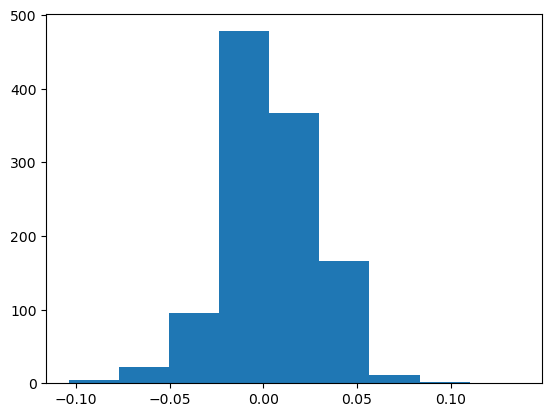

In [41]:
### All code with the forfun designation is about assessing the change in the last round

df_base_rating = pd.DataFrame(df_sr.rating)

run=1
while run < runsize+1:
    result_df=compute_singles_ratings()
    forfun_dict1=df_base_rating['rating'].to_dict()
    df_win1=result_df[['winner1','winner1enddyn']].rename(columns={'winner1':'player', 'winner1enddyn':'rating'})
    df_lose1=result_df[['loser1','loser1enddyn']].rename(columns={'loser1':'player', 'loser1enddyn':'rating'})
    df_base_rating_pre=pd.concat([df_win1,df_lose1])
    df_base_rating=df_base_rating_pre.groupby(['player']).mean('rating')

    #plt.hist(forfun_df2['rating_change'],10)
    if run==runsize:
        sing_rating_pass1_df=df_base_rating_pre.groupby('player')\
                                               .agg(sing_rating=('rating', 'mean')\
                                                    , sing_count=('rating', 'count')).reset_index()
        forfun_df2=df_base_rating_pre.groupby(['player'], as_index=False).mean('rating')
        forfun_df2['pre_rating']=forfun_df2['player'].map(forfun_dict1)
        forfun_df2['rating_change']=forfun_df2['pre_rating']-forfun_df2['rating']
    run=run+1
plt.hist(forfun_df2['rating_change'],9)
#df_add_start_ratings99['rating']=df_add_start_ratings99['position'].map(base_rating_dict)


### Doubles (solo) Execution Code - First Pass

In [42]:
df_base_rating = pd.DataFrame(df_sr.rating)

run=1
while run < runsize+1:
    result_df=compute_doubles_ratings_indv()
    df_win1=result_df[['winner1','winner1enddyn']].rename(columns={'winner1':'player', 'winner1enddyn':'rating'})
    df_win2=result_df[['winner2','winner2enddyn']].rename(columns={'winner2':'player', 'winner2enddyn':'rating'})
    df_lose1=result_df[['loser1','loser1enddyn']].rename(columns={'loser1':'player', 'loser1enddyn':'rating'})
    df_lose2=result_df[['loser2','loser2enddyn']].rename(columns={'loser2':'player', 'loser2enddyn':'rating'})
    df_base_rating_pre=pd.concat([df_win1,df_lose1,df_win2,df_lose2])
    df_base_rating=df_base_rating_pre.groupby(['player']).mean('rating')
    if run==runsize:
        doub_rating_pass1_df=df_base_rating_pre.groupby('player')\
                                               .agg(doub_rating=('rating', 'mean')\
                                                    , doub_count=('rating', 'count')).reset_index()
    
    run=run+1

### Doubles (team) Execution First Pass

(array([  13.,   46.,  209., 1078.,  428.,  182.,   54.,    8.,    4.]),
 array([-0.0901691 , -0.06663732, -0.04310554, -0.01957376,  0.00395802,
         0.0274898 ,  0.05102158,  0.07455335,  0.09808513,  0.12161691]),
 <BarContainer object of 9 artists>)

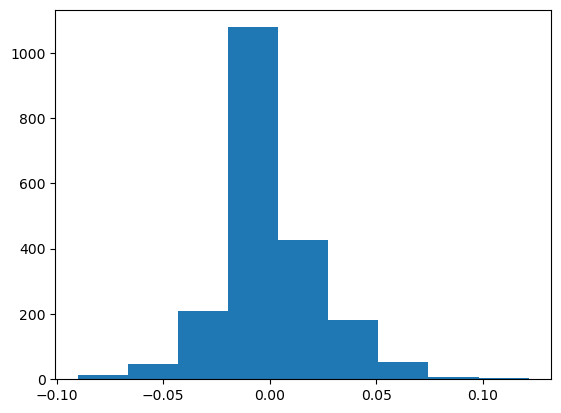

In [43]:
### All code with the forfun designation is about assessing the change in the last round

df_base_rating = df_base_per_team

run=1
while run < runsize+1:
    result_df=compute_doubles_team_ratings()
    forfun_dict1=df_base_rating['rating'].to_dict()
    df_win1=result_df[['winning_team','winning_teamenddyn']].rename(columns={'winning_team':'team', 'winning_teamenddyn':'rating'})
    df_lose1=result_df[['losing_team','losing_teamenddyn']].rename(columns={'losing_team':'team', 'losing_teamenddyn':'rating'})
    df_base_rating_pre=pd.concat([df_win1,df_lose1])
    df_base_rating=df_base_rating_pre.groupby(['team']).mean('rating')

    #plt.hist(forfun_df2['rating_change'],10)
    if run==runsize:
        team_rating_pass1_df_pre=df_base_rating_pre.groupby('team')\
                                               .agg(team_rating=('rating', 'mean')\
                                                    , team_count=('rating', 'count')).reset_index()
        forfun_df2=df_base_rating_pre.groupby(['team'], as_index=False).mean('rating')
        forfun_df2['pre_rating']=forfun_df2['team'].map(forfun_dict1)
        forfun_df2['rating_change']=forfun_df2['pre_rating']-forfun_df2['rating']
    run=run+1
plt.hist(forfun_df2['rating_change'],9)
#df_add_start_ratings99['rating']=df_add_start_ratings99['position'].map(base_rating_dict)


In [44]:
len(team_rating_pass1_df_pre)

2023

In [45]:
"""team_rating_pass1_df['player1']=team_rating_pass1_df['team'].str.split('/', n=1).str[0].astype(int)
team_rating_pass1_df['player2']=team_rating_pass1_df['team'].str.split('/', n=1).str[1].astype(int)

team_p1=team_rating_pass1_df[['player1','team_rating','team_count']].rename(columns={'player1':'player'})
team_p2=team_rating_pass1_df[['player2','team_rating','team_count']].rename(columns={'player2':'player'})

team_pass1=pd.concat([team_p1,team_p2])
team_pass1['rating_total']=team_pass1['team_rating']*team_pass1['team_count']

team_player_pass1_df=team_pass1.groupby('player')\
                                       .agg(team_player_rating=('rating_total', 'sum')\
                                            , team_player_count=('team_count', 'sum')).reset_index()
team_player_pass1_df.head()
"""

"team_rating_pass1_df['player1']=team_rating_pass1_df['team'].str.split('/', n=1).str[0].astype(int)\nteam_rating_pass1_df['player2']=team_rating_pass1_df['team'].str.split('/', n=1).str[1].astype(int)\n\nteam_p1=team_rating_pass1_df[['player1','team_rating','team_count']].rename(columns={'player1':'player'})\nteam_p2=team_rating_pass1_df[['player2','team_rating','team_count']].rename(columns={'player2':'player'})\n\nteam_pass1=pd.concat([team_p1,team_p2])\nteam_pass1['rating_total']=team_pass1['team_rating']*team_pass1['team_count']\n\nteam_player_pass1_df=team_pass1.groupby('player')                                       .agg(team_player_rating=('rating_total', 'sum')                                            , team_player_count=('team_count', 'sum')).reset_index()\nteam_player_pass1_df.head()\n"

### Run the doubles team rescore function

In [46]:
newratelist = team_rating_pass1_df_pre.values.tolist()
doubles_team_rescore()
team_rating_pass1_df=pd.read_csv(sql_csv)
team_rating_pass1_df.head()

We have moved 2023 records from Python to SQLite for Doubles Calculations.
Doubles Player Ratings


,player,team_rating,team_count
0,100003,24.43,11
1,100041,17.25,9
2,100057,21.86,11
3,100059,25.59,13
4,100060,25.59,13


In [47]:
# This can be less than the number of teams (4 players could combine to be 6 teams) - it's just a check.  
len(team_rating_pass1_df)

1881

### Create a mid-run rating that combines singles and doubles weighted averages
##### Most notably for when a really highly rated singles player plays one doubles match and destroys highly rated doubles players

In [48]:
print(sing_rating_pass1_df.head())
print(" ")
print(doub_rating_pass1_df.head())
print(" ")
print(team_rating_pass1_df.head())


   player  sing_rating  sing_count
0   80635    22.914281           5
1   80636    17.381240           1
2   81005    16.321574           5
3   98157    26.621095           3
4   98158    28.732080          19
 
   player  doub_rating  doub_count
0   80635    22.600507           1
1   80636    17.613887           6
2   98157    27.747537          12
3   98682    27.056118          15
4   98776    24.789711           1
 
   player  team_rating  team_count
0  100003        24.43          11
1  100041        17.25           9
2  100057        21.86          11
3  100059        25.59          13
4  100060        25.59          13


#### This can either use the solo/indv doubles method or the team-based method - set at the very top of the code

In [49]:
df_mid_prep=df_sr.merge(sing_rating_pass1_df, on = 'player', how='left')\
                           .merge(doub_rating_pass1_df, on = 'player', how='left')\
                           .merge(team_rating_pass1_df, on = 'player', how='left')
df_mid_prep.fillna(0,inplace=True)
if doubles_method=='indv':
    df_mid_prep['mid_rating']=(df_mid_prep['sing_rating']*df_mid_prep['sing_count']\
                              +df_mid_prep['doub_rating']*df_mid_prep['doub_count'])\
                              /(df_mid_prep['sing_count']+df_mid_prep['doub_count'])
else:
    df_mid_prep['mid_rating']=(df_mid_prep['sing_rating']*df_mid_prep['sing_count']\
                              +df_mid_prep['team_rating']*df_mid_prep['team_count'])\
                              /(df_mid_prep['sing_count']+df_mid_prep['team_count'])
df_mid=df_mid_prep.drop(['rating','sing_rating','sing_count','doub_rating','doub_count','team_rating','team_count'],axis=1)

df_mid.set_index('player',inplace=True)
print(df_mid_prep.head(10))
print(df_mid.head(10))

   player     rating  sing_rating  sing_count  doub_rating  doub_count  \
0   80635  23.366667    22.914281         5.0    22.600507         1.0   
1   80636  22.785714    17.381240         1.0    17.613887         6.0   
2   81005  23.400000    16.321574         5.0     0.000000         0.0   
3   98157  22.660000    26.621095         3.0    27.747537        12.0   
4   98158  27.000000    28.732080        19.0     0.000000         0.0   
5   98682  22.693333     0.000000         0.0    27.056118        15.0   
6   98776  23.200000     0.000000         0.0    24.789711         1.0   
7   98778  20.100000     0.000000         0.0    22.600000         1.0   
8   98779  23.400000    26.150000         1.0     0.000000         0.0   
9   98784  20.100000     0.000000         0.0    22.600000         1.0   

   team_rating  team_count  mid_rating  
0        24.38         1.0   23.158567  
1        17.91         6.0   17.834463  
2         0.00         0.0   16.321574  
3        29.81       

## Singles Ratings 2nd Pass

(array([  1.,   0.,   5.,   7.,  50., 567., 394., 111.,  11.,   1.]),
 array([-0.09326991, -0.07763395, -0.061998  , -0.04636204, -0.03072609,
        -0.01509014,  0.00054582,  0.01618177,  0.03181772,  0.04745368,
         0.06308963]),
 <BarContainer object of 10 artists>)

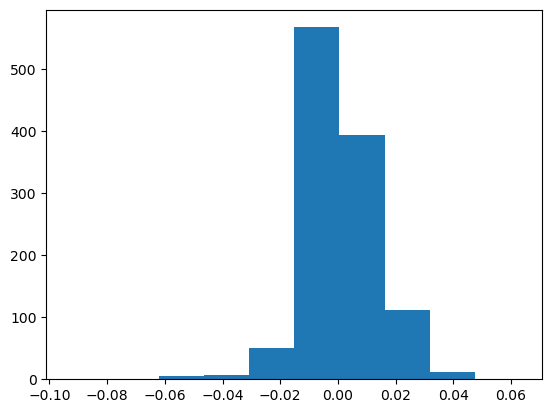

In [50]:
df_base_rating = df_mid.rename(columns={'mid_rating':'rating'})

run=1
while run < runsize+1:
    result_df=compute_singles_ratings()
    forfun_dict1=df_base_rating['rating'].to_dict()
    df_win1=result_df[['winner1','winner1enddyn']].rename(columns={'winner1':'player', 'winner1enddyn':'rating'})
    df_lose1=result_df[['loser1','loser1enddyn']].rename(columns={'loser1':'player', 'loser1enddyn':'rating'})
    df_base_rating_pre=pd.concat([df_win1,df_lose1])
    df_base_rating=df_base_rating_pre.groupby(['player']).mean('rating')

    #plt.hist(forfun_df2['rating_change'],10)
    if run==runsize:
        sing_rating_pass2_df=df_base_rating_pre.groupby('player')\
                                               .agg(sing_rating=('rating', 'mean')\
                                                    , sing_count=('rating', 'count')).reset_index()
        forfun_df2=df_base_rating_pre.groupby(['player'], as_index=False).mean('rating')
        forfun_df2['pre_rating']=forfun_df2['player'].map(forfun_dict1)
        forfun_df2['rating_change']=forfun_df2['pre_rating']-forfun_df2['rating']
    run=run+1
plt.hist(forfun_df2['rating_change'],10)
#df_add_start_ratings99['rating']=df_add_start_ratings99['position'].map(base_rating_dict)


## Doubles Ratings - 2nd Pass (solo)

In [51]:
df_base_rating = df_mid.rename(columns={'mid_rating':'rating'})

run=1
while run < runsize+1:
    result_df=compute_doubles_ratings_indv()
    df_win1=result_df[['winner1','winner1enddyn']].rename(columns={'winner1':'player', 'winner1enddyn':'rating'})
    df_win2=result_df[['winner2','winner2enddyn']].rename(columns={'winner2':'player', 'winner2enddyn':'rating'})
    df_lose1=result_df[['loser1','loser1enddyn']].rename(columns={'loser1':'player', 'loser1enddyn':'rating'})
    df_lose2=result_df[['loser2','loser2enddyn']].rename(columns={'loser2':'player', 'loser2enddyn':'rating'})
    df_base_rating_pre=pd.concat([df_win1,df_lose1,df_win2,df_lose2])
    df_base_rating=df_base_rating_pre.groupby(['player']).mean('rating')
    if run==runsize:
        doub_rating_pass2_df=df_base_rating_pre.groupby('player')\
                                               .agg(doub_rating=('rating', 'mean')\
                                                    , doub_count=('rating', 'count')).reset_index()
    
    run=run+1

## Doubles Ratings - 2nd Pass (team)

### Need to re-create the base rating per team first

In [52]:
#df_add_start_ratings=df_mf.merge(df_rating_assumptions, on = 'position', how='left')
#df_add_start_ratings.head()
df_temp1=df_teams.merge(df_mid, left_on = 'player1', right_on='player', how='left')\
                 .merge(df_mid, left_on = 'player2', right_on='player', how='left')

df_temp1['rating']=round((df_temp1['mid_rating_x']+df_temp1['mid_rating_y'])/2,3)

df_base_per_team=df_temp1.drop(['player1','player2','mid_rating_x','mid_rating_y'],axis=1).set_index('team')
df_base_per_team.head()


,rating
team,
121901/99666,28.047
141666/141667,25.415
121903/99667,21.100
141669/164691,21.700
100765/164250,25.568


(array([   5.,   24.,  102., 1254.,  505.,   85.,   39.,    4.,    4.]),
 array([-0.05751437, -0.04263635, -0.02775832, -0.0128803 ,  0.00199773,
         0.01687575,  0.03175378,  0.0466318 ,  0.06150982,  0.07638785]),
 <BarContainer object of 9 artists>)

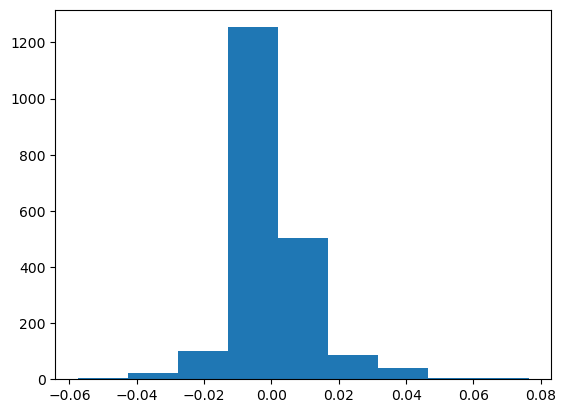

In [53]:
df_base_rating = df_base_per_team

run=1
while run < runsize+1:
    result_df=compute_doubles_team_ratings()
    forfun_dict1=df_base_rating['rating'].to_dict()
    df_win1=result_df[['winning_team','winning_teamenddyn']].rename(columns={'winning_team':'team', 'winning_teamenddyn':'rating'})
    df_lose1=result_df[['losing_team','losing_teamenddyn']].rename(columns={'losing_team':'team', 'losing_teamenddyn':'rating'})
    df_base_rating_pre=pd.concat([df_win1,df_lose1])
    df_base_rating=df_base_rating_pre.groupby(['team']).mean('rating')

    #plt.hist(forfun_df2['rating_change'],10)
    if run==runsize:
        team_rating_pass2_df=df_base_rating_pre.groupby('team')\
                                               .agg(team_rating=('rating', 'mean')\
                                                    , team_count=('rating', 'count')).reset_index()
        forfun_df2=df_base_rating_pre.groupby(['team'], as_index=False).mean('rating')
        forfun_df2['pre_rating']=forfun_df2['team'].map(forfun_dict1)
        forfun_df2['rating_change']=forfun_df2['pre_rating']-forfun_df2['rating']
    run=run+1
plt.hist(forfun_df2['rating_change'],9)
#df_add_start_ratings99['rating']=df_add_start_ratings99['position'].map(base_rating_dict)


In [54]:
newratelist = team_rating_pass2_df.values.tolist()
doubles_team_rescore()
team_rating_pass2_df=pd.read_csv(sql_csv)

We have moved 2023 records from Python to SQLite for Doubles Calculations.
Doubles Player Ratings


In [55]:
df_final_prep=df_sr.merge(sing_rating_pass2_df, on = 'player', how='left')\
                            .merge(doub_rating_pass2_df, on = 'player', how='left')\
                            .merge(team_rating_pass2_df, on = 'player', how='left')
df_final_prep.fillna(0,inplace=True)
if doubles_method=='indv':
    df_final_prep['final_rating']=(df_final_prep['sing_rating']*df_final_prep['sing_count']\
                              +df_final_prep['doub_rating']*df_final_prep['doub_count'])\
                              /(df_final_prep['sing_count']+df_final_prep['doub_count'])
else:
    df_final_prep['final_rating']=(df_final_prep['sing_rating']*df_final_prep['sing_count']\
                              +df_final_prep['team_rating']*df_final_prep['team_count'])\
                              /(df_final_prep['sing_count']+df_final_prep['team_count'])

df_final_prep.drop(['rating'],axis=1,inplace=True)

In [56]:
df_final=df_final_prep.merge(df_supp_file, on = 'player', how='left')
df_final.head()

,player,sing_rating,sing_count,doub_rating,doub_count,team_rating,team_count,final_rating,player_name,grade,school_name,class,league
0,80635,22.142630,5.0,21.999703,1.0,24.07,1.0,22.463858,Halle Shearer,12.0,Riverdale,3A,SD1
1,80636,16.350747,1.0,18.417591,6.0,15.97,6.0,16.024392,Hannah Millkey,12.0,Riverdale,3A,SD1
2,81005,15.641459,5.0,0.000000,0.0,0.00,0.0,15.641459,Sophie Qualls,12.0,Ione-Heppner,1A,SD4
3,98157,26.781455,3.0,29.278442,12.0,30.22,12.0,29.532291,Hailey Foley,12.0,Sherwood,6A,Pacific
4,98158,29.091045,19.0,0.000000,0.0,0.00,0.0,29.091045,Vicky Nguyen,12.0,Sherwood,6A,Pacific


In [57]:
df_final.sort_values(by=['school_name','final_rating'],ascending=[True,False],inplace=True)
df_final['rand_add']=np.random.uniform(0.000001, 0.009999, size=len(df_final))
df_final['fin_rat_adj']=df_final['final_rating']+df_final['rand_add']
df_final['rank_in_school']=df_final.groupby('school_name')['fin_rat_adj'].rank(ascending=False, method='dense')
df_export=df_final.drop(['rand_add','fin_rat_adj'],axis=1)
#df_export=df_final
df_export.to_csv(final_output_csv_loc)

#player_set={79729,123420,123082,74842,74850}
#df_5players=df_final[df_final['player'].isin(player_set)]
#df_5players.sort_values(by=['final_rating'], ascending=False,inplace=True)
#df_5players

In [58]:
df_final2=df_final
"""
df_final2['rand_add']=np.random.uniform(0.000001, 0.009999, size=len(df_final2))
df_final2['fin_rat_adj']=df_final2['final_rating']+df_final2['rand_add']
df_final2['rank_in_school']=df_final2.groupby('school_name')['fin_rat_adj'].rank(ascending=False, method='dense')
"""


"\ndf_final2['rand_add']=np.random.uniform(0.000001, 0.009999, size=len(df_final2))\ndf_final2['fin_rat_adj']=df_final2['final_rating']+df_final2['rand_add']\ndf_final2['rank_in_school']=df_final2.groupby('school_name')['fin_rat_adj'].rank(ascending=False, method='dense')\n"

In [59]:
df_top_20=df_final[['player','player_name','school_name','grade','final_rating']].copy()
df_top_20.sort_values(by=['final_rating'],ascending=False,inplace=True)
print("Top 20 Players Overall")
print(df_top_20.head(20).to_string(index=False))

Top 20 Players Overall
 player          player_name         school_name  grade  final_rating
 123420          Raegan Farm          North Bend   11.0     38.835404
 141640       Whitney Hedden     Marist Catholic   10.0     37.281188
 145172         Kate Bonetto              Summit   10.0     36.912554
 164183 Nikhitha Raji Suresh            Westview   11.0     36.113921
 123263        Sonya Drayton           West Linn   11.0     35.752182
 140879     Carlyta Barfield              Benson   10.0     35.620292
 104618       Kennedy Harris       La Salle Prep   12.0     35.362679
 124077       Malavika Rahul            Westview   11.0     34.616020
 121360             Emily Gu     Crescent Valley   11.0     34.469854
 164184          Vivienne Lu            Westview    9.0     34.463191
 143078       Alexis Uschold       South Medford   10.0     33.931090
 163631             Leah Lup           West Linn    9.0     33.813401
 141982       Sofia Sorokina             Nelson    10.0     33.7019

In [60]:
df_top_20_sing=df_final[['player','player_name','school_name','grade','sing_rating']].copy()
df_top_20_sing.sort_values(by=['sing_rating'],ascending=False,inplace=True)
print("Top 20 Singles Players")
print(df_top_20_sing.head(20).to_string(index=False))

Top 20 Singles Players
 player          player_name         school_name  grade  sing_rating
 123420          Raegan Farm          North Bend   11.0    38.835404
 141640       Whitney Hedden     Marist Catholic   10.0    37.281188
 145172         Kate Bonetto              Summit   10.0    36.912554
 123263        Sonya Drayton           West Linn   11.0    36.864618
 164183 Nikhitha Raji Suresh            Westview   11.0    36.326747
 119281         Amanda Perez Catlin Gabel School   11.0    36.063924
 140879     Carlyta Barfield              Benson   10.0    35.620292
 121360             Emily Gu     Crescent Valley   11.0    35.519780
 143078       Alexis Uschold       South Medford   10.0    35.378999
 104618       Kennedy Harris       La Salle Prep   12.0    35.362679
 164184          Vivienne Lu            Westview    9.0    34.538457
 163631             Leah Lup           West Linn    9.0    33.813401
 141982       Sofia Sorokina             Nelson    10.0    33.701971
 121899    

In [61]:
print(df_top_20_sing.head(50).to_string(index=False))

 player          player_name             school_name  grade  sing_rating
 123420          Raegan Farm              North Bend   11.0    38.835404
 141640       Whitney Hedden         Marist Catholic   10.0    37.281188
 145172         Kate Bonetto                  Summit   10.0    36.912554
 123263        Sonya Drayton               West Linn   11.0    36.864618
 164183 Nikhitha Raji Suresh                Westview   11.0    36.326747
 119281         Amanda Perez     Catlin Gabel School   11.0    36.063924
 140879     Carlyta Barfield                  Benson   10.0    35.620292
 121360             Emily Gu         Crescent Valley   11.0    35.519780
 143078       Alexis Uschold           South Medford   10.0    35.378999
 104618       Kennedy Harris           La Salle Prep   12.0    35.362679
 164184          Vivienne Lu                Westview    9.0    34.538457
 163631             Leah Lup               West Linn    9.0    33.813401
 141982       Sofia Sorokina                 Nelson

In [62]:
df_top_20_doub=df_final[['player','player_name','school_name','grade','doub_rating','doub_count']].copy()
df_top_20_doub.sort_values(by=['doub_rating'],ascending=False,inplace=True)
print("Top 20 Doubles Players")
print(df_top_20_doub.head(20).to_string(index=False))

Top 20 Doubles Players
 player          player_name         school_name  grade  doub_rating  doub_count
 101950       Adeline Backer               Grant   12.0    36.071322         2.0
 100675     Brooklyn Lindsey             Redmond   12.0    34.532397         4.0
 143078       Alexis Uschold       South Medford   10.0    34.389881         3.0
 164183 Nikhitha Raji Suresh            Westview   11.0    34.238220         1.0
 124077       Malavika Rahul            Westview   11.0    34.167605         8.0
 142664            Keira Lin     Crescent Valley   10.0    34.050102         3.0
 119281         Amanda Perez Catlin Gabel School   11.0    33.354360         4.0
 164184          Vivienne Lu            Westview    9.0    32.873973         1.0
 103807          Evelyn Park              Sunset   12.0    32.355750         5.0
 143585         Alexa Clarke           Beaverton   10.0    32.190336         3.0
  99948                  NaN                 NaN    NaN    32.002674         1.0
 1412

In [63]:
df_top_20_doub=df_final[['player','player_name','school_name','grade','team_rating','team_count']].copy()
df_top_20_doub.sort_values(by=['team_rating'],ascending=False,inplace=True)
print("Top 20 Doubles Players")
print(df_top_20_doub.head(50).to_string(index=False))

Top 20 Doubles Players
 player          player_name             school_name  grade  team_rating  team_count
 124077       Malavika Rahul                Westview   11.0        35.17         8.0
 164184          Vivienne Lu                Westview    9.0        33.56         1.0
 164183 Nikhitha Raji Suresh                Westview   11.0        33.56         1.0
 121360             Emily Gu         Crescent Valley   11.0        32.37         1.0
 143730         Sitara Soman                 Lincoln   10.0        32.34         5.0
 101950       Adeline Backer                   Grant   12.0        31.98         2.0
 141222                  NaN                     NaN    NaN        31.87         1.0
  99948                  NaN                     NaN    NaN        31.87         1.0
  99552           Kate Paine                 Jesuit    12.0        31.82         1.0
 131711      Sydney Chandler            South Eugene   11.0        31.76         8.0
 119281         Amanda Perez     Catlin Ga

In [64]:
df_new=df_top_20_doub.loc[df_top_20_doub.team_count>=6]

In [65]:
df_new.head(40)

,player,player_name,school_name,grade,team_rating,team_count
630,124077,Malavika Rahul,Westview,11.0,35.17,8.0
710,131711,Sydney Chandler,South Eugene,11.0,31.76,8.0
246,107511,Tessa Rozendal,Westview,12.0,31.06,10.0
130,101459,Elise Seals,Vale,12.0,30.51,13.0
838,141895,Ellie Seals,Vale,10.0,30.51,13.0
121,101174,Kate Eames,Lake Oswego,12.0,30.36,9.0
3,98157,Hailey Foley,Sherwood,12.0,30.22,12.0
1072,143729,Reese Hefele,Lincoln,10.0,30.08,6.0
490,122724,Alyssa Piquette,Sheldon,11.0,30.08,19.0
1773,164689,Olivia Hasle,Jesuit,9.0,30.03,6.0


## Do some school/team grouping, sorting, rating and show some visuals

<Axes: title={'center': 'Doubles Rating Differences from different calculation methods'}, xlabel='Using Team Ratings Then Separating', ylabel='Using Individual Ratings'>

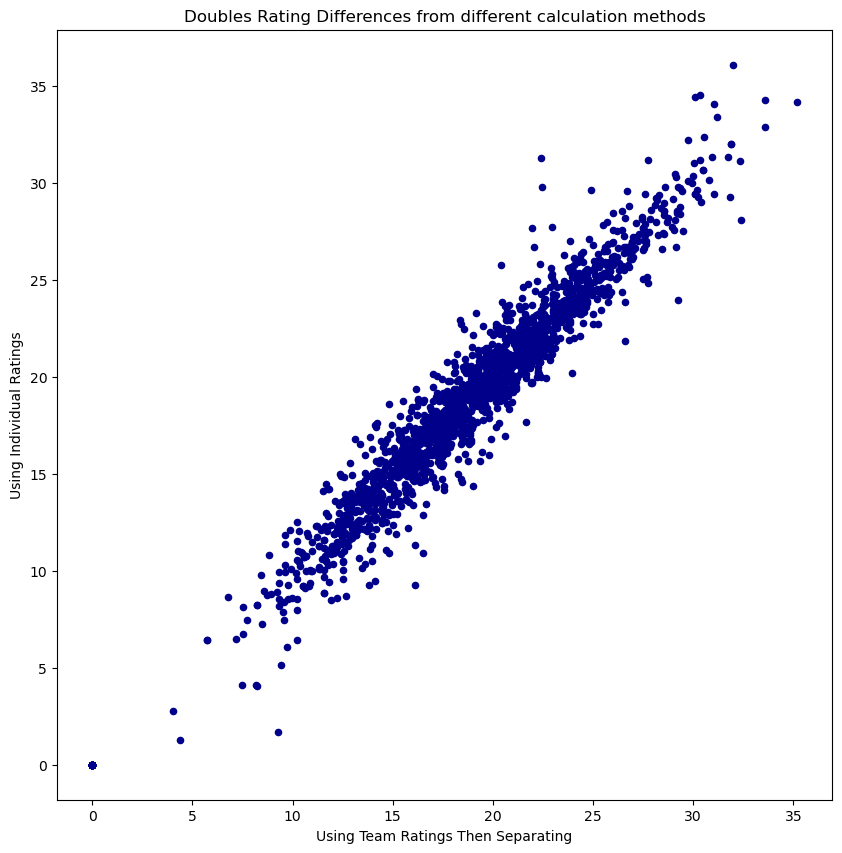

In [66]:
df_final.plot(kind='scatter', x='team_rating', y='doub_rating', figsize=(10, 10), color='darkblue'\
              , title='Doubles Rating Differences from different calculation methods'\
              ,ylabel='Using Individual Ratings',xlabel='Using Team Ratings Then Separating')

In [67]:
#df_counting_schools=df_12_plus.drop(['count'],axis=1)

In [68]:
# Reduce each school to their top 12 for school ranking purposes
df_top12_per_school=df_final2[df_final2['rank_in_school'] <= 12]

In [69]:
print(len(df_final2))
print(len(df_top12_per_school))

2193
1445


In [70]:
df_school_size=pd.DataFrame(df_top12_per_school.value_counts('school_name'))

In [71]:
df_school_size.value_counts('count')

count
12    115
7       2
2       1
5       1
6       1
8       1
9       1
10      1
11      1
Name: count, dtype: int64

In [72]:
df_top12_per_school.head()

,player,sing_rating,sing_count,doub_rating,doub_count,team_rating,team_count,final_rating,player_name,grade,school_name,class,league,rand_add,fin_rat_adj,rank_in_school
1296,145253,22.781709,14.0,0.00000,0.0,0.00,0.0,22.781709,Maya Wasmann,10.0,Roosevelt,6A,PIL,0.006643,22.788352,1.0
2052,168894,21.368665,12.0,0.00000,0.0,0.00,0.0,21.368665,Olive Konig Wilcox,9.0,Roosevelt,6A,PIL,0.000745,21.369411,2.0
2053,168897,0.000000,0.0,15.57828,10.0,16.44,10.0,16.440000,Maya Mazariegos,9.0,Roosevelt,6A,PIL,0.006992,16.446992,3.0
658,124832,17.103500,1.0,16.52211,10.0,16.37,10.0,16.436682,Guadalupe Ramirez,11.0,Roosevelt,6A,PIL,0.000720,16.437402,4.0
1298,145256,14.978312,2.0,0.00000,0.0,0.00,0.0,14.978312,Gloria Zawadi,12.0,Roosevelt,6A,PIL,0.007311,14.985623,5.0


### Keeping 12 Plus just in case the random addition still created a tie (1 in 10000 chance)

In [73]:
df_12_plus=df_school_size[df_school_size['count'] >= 12]

In [74]:
df_12_plus.reset_index(drop=False,inplace=True)
df_counting_schools=df_12_plus.drop(['count'],axis=1)

In [75]:
df_team_analysis=df_top12_per_school.merge(df_counting_schools, on = 'school_name', how='inner')

In [76]:
df_team_avg=df_team_analysis.groupby('school_name')['final_rating'].mean().reset_index()

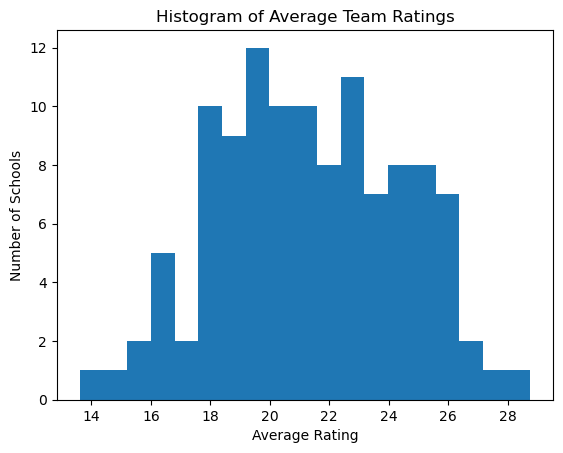

In [77]:
plt.hist(df_team_avg['final_rating'],19)
plt.title('Histogram of Average Team Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Schools')

plt.show()

In [78]:
df_team_avg.sort_values(by=['final_rating'],ascending=False,inplace=True)
print("Top 20 Teams by Top 12 Rating Average")
print(df_team_avg.head(20).to_string(index=False))

Top 20 Teams by Top 12 Rating Average
         school_name  final_rating
             Jesuit      28.773299
            Westview     27.237340
     Marist Catholic     26.408325
       Mountainside      26.392807
               Grant     26.372778
             Sheldon     26.112849
              Summit     25.995238
              Sunset     25.890648
     Crescent Valley     25.778725
             Lincoln     25.739562
         Lake Oswego     25.704990
           Lakeridge     25.565947
             Redmond     25.418127
       La Salle Prep     25.324544
St Mary's of Medford     25.198355
 Catlin Gabel School     25.158566
         McMinnville     25.120906
            Sherwood     25.105406
           West Linn     24.874340
             Nelson      24.705074


In [79]:
print("Bottom 10 Teams by Top 12 Rating Average")
print(df_team_avg.tail(10).to_string(index=False))

Bottom 10 Teams by Top 12 Rating Average
                            school_name  final_rating
                               Estacada     17.037235
                                Phoenix     16.673249
                 Central (Independence)     16.485262
Milwaukie / Milwaukie Acad. of the Arts     16.336617
                        Trinity Academy     16.207672
                              Roosevelt     16.177411
                               Reynolds     15.723367
                                 Putnam     15.636005
                                 Mazama     14.785713
                            North Salem     13.599728


In [80]:
df_pc=df_team_analysis[df_team_analysis['league']=='Pacific']

df_pc_avg=df_pc.groupby('school_name')['final_rating'].mean().reset_index()
df_pc_avg.sort_values(by=['final_rating'],ascending=False,inplace=True)
print("Pacific Conference Teams - Average Top 12 Player Rating")
print(df_pc_avg.head(7).to_string(index=False))

Pacific Conference Teams - Average Top 12 Player Rating
 school_name  final_rating
 McMinnville     25.120906
    Sherwood     25.105406
Forest Grove     22.444530
     Glencoe     21.568906
     Newberg     20.701410
     Century     19.409238
     Liberty     18.366141


### For a 12-player team, the ends of the box (25th/75th percentile) are players ranked 4 and 8
### Shown below, a team rated as:  10, 11, 12, 12, 12.3, 12.3, 13.7, 13.7, 13.7, 14, 15, 16
### With 12 showing as the 25th percentile and 13.7 as the 75th

[Text(0.5, 1.0, 'Team Box Plot Example - See Comments Above'),
 Text(0.5, 0, 'Final Rating'),
 Text(0, 0.5, '')]

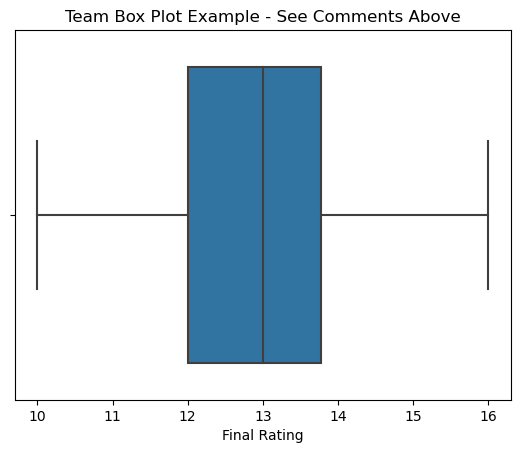

In [81]:
data = {'final_rating': [10,11,12,12,12.3,12.3,13.7,13.7,13.7,14,15,16]}
df = pd.DataFrame(data)
sns.boxplot(x=df['final_rating'])\
           .set(title='Team Box Plot Example - See Comments Above',xlabel='Final Rating',ylabel=None)

[Text(0.5, 1.0, 'Pacific Conference Team Box Plot'),
 Text(0.5, 0, 'Final Rating'),
 Text(0, 0.5, '')]

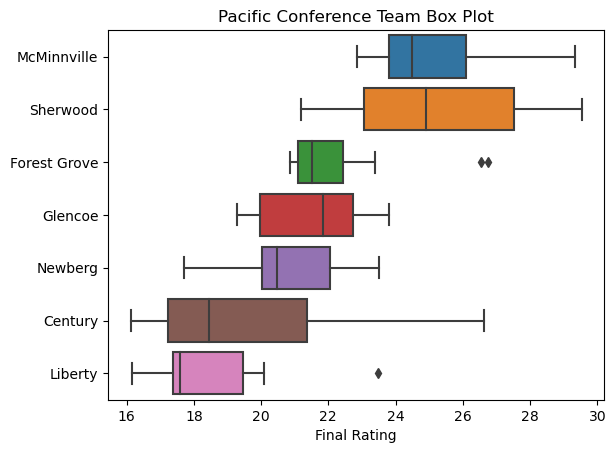

In [82]:
order_pc_list=df_pc_avg['school_name'].tolist()
 
sns.boxplot(x=df_pc['final_rating'], y=df_pc['school_name'], order=order_pc_list)\
           .set(title='Pacific Conference Team Box Plot',xlabel='Final Rating',ylabel=None)

[Text(0.5, 1.0, 'Ratings by 6A League'),
 Text(0.5, 0, 'Final Rating'),
 Text(0, 0.5, '')]

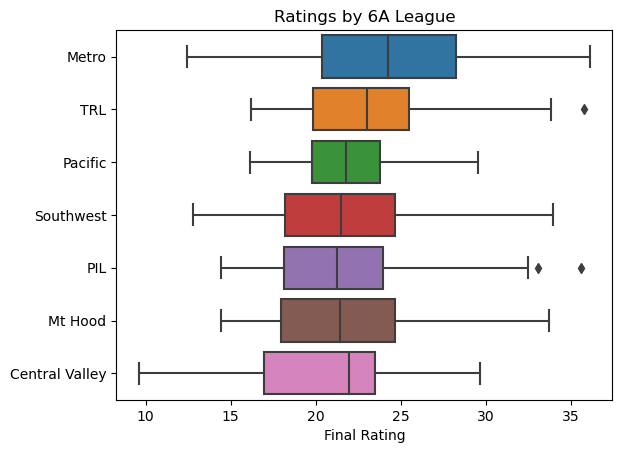

In [83]:
df_6a=df_team_analysis[df_team_analysis['class']=='6A']

df_6a_league_avg=df_6a.groupby('league')['final_rating'].mean().reset_index()
df_6a_league_avg.sort_values(by=['final_rating'],ascending=False,inplace=True)
order_6a_league_list=df_6a_league_avg['league'].tolist()

sns.boxplot(x=df_6a['final_rating'], y=df_6a['league'], order=order_6a_league_list)\
           .set(title='Ratings by 6A League',xlabel='Final Rating',ylabel=None)

[Text(0.5, 1.0, 'Ratings by 5A League'),
 Text(0.5, 0, 'Final Rating'),
 Text(0, 0.5, '')]

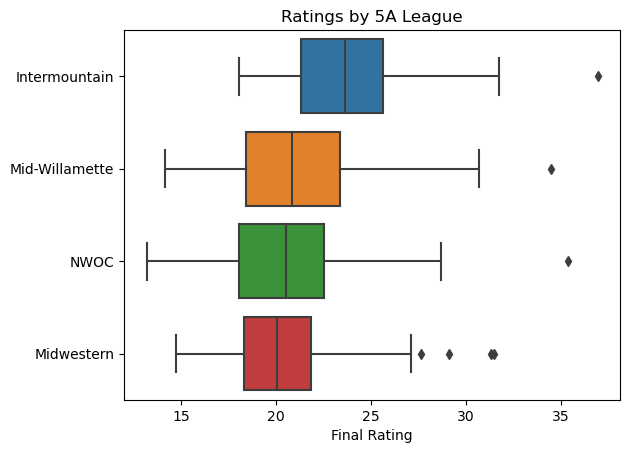

In [84]:
df_5a=df_team_analysis[df_team_analysis['class']=='5A']

df_5a_league_avg=df_5a.groupby('league')['final_rating'].mean().reset_index()
df_5a_league_avg.sort_values(by=['final_rating'],ascending=False,inplace=True)
order_5a_league_list=df_5a_league_avg['league'].tolist()

sns.boxplot(x=df_5a['final_rating'], y=df_5a['league'], order=order_5a_league_list)\
           .set(title='Ratings by 5A League',xlabel='Final Rating',ylabel=None)

In [85]:
df_nwoc=df_team_analysis[df_team_analysis['league']=='NWOC']

df_nwoc_avg=df_nwoc.groupby('school_name')['final_rating'].mean().reset_index()
df_nwoc_avg.sort_values(by=['final_rating'],ascending=False,inplace=True)
print("NWOC Teams - Average Top 12 Player Rating")
print(df_nwoc_avg.head(9).to_string(index=False))

NWOC Teams - Average Top 12 Player Rating
                            school_name  final_rating
                          La Salle Prep     25.324544
                      Hood River Valley     24.406188
                                  Canby     21.246350
                            Wilsonville     21.005936
                               Parkrose     20.920658
                             Centennial     20.450743
                              Hillsboro     19.454852
Milwaukie / Milwaukie Acad. of the Arts     16.336617
                                 Putnam     15.636005


[Text(0.5, 1.0, 'Northwest Oregon Team Box Plot'),
 Text(0.5, 0, 'Final Rating'),
 Text(0, 0.5, '')]

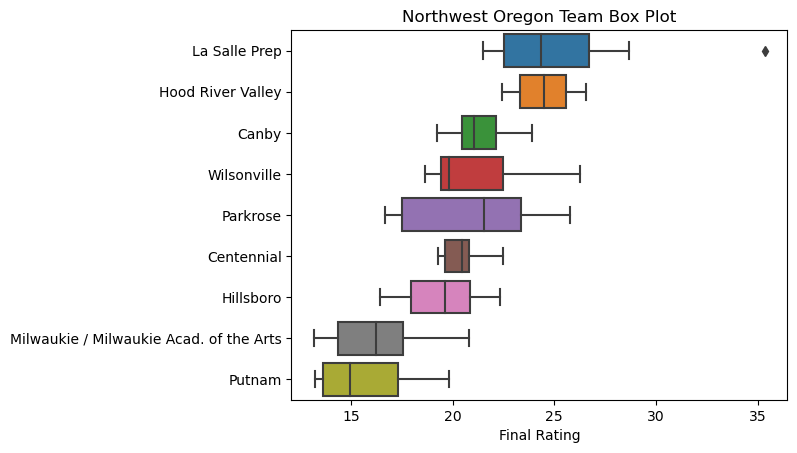

In [86]:
order_nwoc_list=df_nwoc_avg['school_name'].tolist()
 
sns.boxplot(x=df_nwoc['final_rating'], y=df_nwoc['school_name'], order=order_nwoc_list)\
           .set(title='Northwest Oregon Team Box Plot',xlabel='Final Rating',ylabel=None)

By Classification - Average Top 12 Player Rating
class  final_rating
   3A     22.993072
   6A     22.036249
   5A     21.276294
   4A     20.175187
   2A     19.380394
   1A     18.455922


[Text(0.5, 1.0, 'Classification Box Plot'),
 Text(0.5, 0, 'Final Rating'),
 Text(0, 0.5, '')]

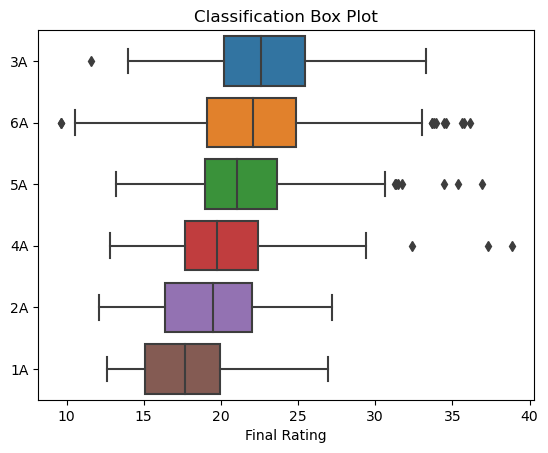

In [87]:
df_class_avg=df_team_analysis.groupby('class')['final_rating'].mean().reset_index()
df_class_avg.sort_values(by=['final_rating'],ascending=False,inplace=True)
print("By Classification - Average Top 12 Player Rating")
print(df_class_avg.head(6).to_string(index=False))

order_class_list=df_class_avg['class'].tolist()
 
sns.boxplot(x=df_team_analysis['final_rating'], y=df_team_analysis['class'], order=order_class_list)\
           .set(title='Classification Box Plot',xlabel='Final Rating',ylabel=None)

In [88]:
#print(df_matchfile_whole.head())
#print(df_export.head())
df_rating_only=df_export[['player','final_rating','player_name']]
df_rating_only.head()

,player,final_rating,player_name
1296,145253,22.781709,Maya Wasmann
2052,168894,21.368665,Olive Konig Wilcox
2053,168897,16.440000,Maya Mazariegos
658,124832,16.436682,Guadalupe Ramirez
1298,145256,14.978312,Gloria Zawadi


In [89]:
df_match_wins1=df_rating_only.merge(df_matchfile_whole, left_on = 'player', right_on='winner1', how='inner')
df_match_wins1.drop(['team_match_id','winner1','winner1_name','winner2_name','loser1_name','loser2_name'],axis=1,inplace=True)
df_match_wins1.rename(columns={'winner2':'partner_id','winner2_name':'partner_name'},inplace=True)
df_match_wins1b=df_match_wins1.merge(df_rating_only, left_on = 'partner_id', right_on='player', how='left', suffixes=('', '_partner'))
df_match_wins1c=df_match_wins1b.merge(df_rating_only, left_on = 'loser1', right_on='player', how='left', suffixes=('', '_opp1'))
df_match_wins1d=df_match_wins1c.merge(df_rating_only, left_on = 'loser2', right_on='player', how='left', suffixes=('', '_opp2'))
df_match_wins1d.drop(['partner_id','loser1','loser2','player_partner','player_opp1','player_opp2'],axis=1,inplace=True)

df_match_wins2=df_rating_only.merge(df_matchfile_whole, left_on = 'player', right_on='winner2', how='inner')
df_match_wins2.drop(['team_match_id','winner2','winner1_name','winner2_name','loser1_name','loser2_name'],axis=1,inplace=True)
df_match_wins2.rename(columns={'winner1':'partner_id','winner1_name':'partner_name'},inplace=True)
df_match_wins2b=df_match_wins2.merge(df_rating_only, left_on = 'partner_id', right_on='player', how='left', suffixes=('', '_partner'))
df_match_wins2c=df_match_wins2b.merge(df_rating_only, left_on = 'loser1', right_on='player', how='left', suffixes=('', '_opp1'))
df_match_wins2d=df_match_wins2c.merge(df_rating_only, left_on = 'loser2', right_on='player', how='left', suffixes=('', '_opp2'))
df_match_wins2d.drop(['partner_id','loser1','loser2','player_partner','player_opp1','player_opp2'],axis=1,inplace=True)

In [90]:
df_match_wins2d.head(10)

,player,final_rating,player_name,matchid,match_dt,position,set1,set2,set3,final_rating_partner,player_name_partner,final_rating_opp1,player_name_opp1,final_rating_opp2,player_name_opp2
0,168897,16.440000,Maya Mazariegos,1319356,2025-05-08,DX,6*0,6*1,0*0,16.436682,Guadalupe Ramirez,12.190807,Esme Dawkins,10.244306,Argus Ferey
1,168897,16.440000,Maya Mazariegos,1285411,2025-04-21,D2,6*1,6*4,0*0,16.436682,Guadalupe Ramirez,11.832413,Cherish Mercado,14.103381,Ta'Resia Lopez
2,168897,16.440000,Maya Mazariegos,1260742,2025-04-08,D1,7*6,7*6,0*0,16.436682,Guadalupe Ramirez,19.360000,Aranza Alfaro,12.340000,Zuleika Rivera Hernandez
3,168898,13.410000,Daphne Petit,1300338,2025-04-28,D3,0*6,4*6,1*0,14.520000,Grace Keady,12.520000,Liliana Shaykin,13.933025,Bella Van Dordrecht
4,168898,13.410000,Daphne Petit,1260746,2025-04-08,D3,6*4,6*4,0*0,14.520000,Grace Keady,13.710000,Tori Leatham,12.468430,Lilly Grassman
5,168892,10.960000,Marilyn Hernandez Marcial,1285413,2025-04-21,D3,2*6,6*2,1*0,14.509695,Gizelle Gonzalez Ramirez,15.114831,Amy Vasquez,16.170000,Sarinem Kasanmoesdiran
6,143247,22.203897,Perla Sanchez,1306072,2025-04-30,D1,4*6,6*4,6*2,24.290000,Megan Vandehey,20.325489,Delfina Campos Reyes,24.509279,Miah Bernhardt
7,143247,22.203897,Perla Sanchez,1300403,2025-04-28,D1,6*4,6*3,0*0,24.290000,Megan Vandehey,23.205346,Faye Scott,19.804549,Julia Galagate
8,143247,22.203897,Perla Sanchez,1279751,2025-04-18,D1,7*5,6*4,0*0,24.290000,Megan Vandehey,21.000000,Shannon Lin,23.030000,Sarah Nguyen
9,143247,22.203897,Perla Sanchez,1273813,2025-04-15,D1,6*4,6*2,0*0,24.290000,Megan Vandehey,20.270000,Jacky Arzate,20.270000,Carolina (Zoe) Rodriguez


In [91]:
df_match_loss1=df_rating_only.merge(df_matchfile_whole, left_on = 'player', right_on='loser1', how='inner')
df_match_loss1.drop(['team_match_id','loser1','winner1_name','winner2_name','loser1_name','loser2_name'],axis=1,inplace=True)
df_match_loss1.rename(columns={'loser2':'partner_id','loser2_name':'partner_name'},inplace=True)
df_match_loss1b=df_match_loss1.merge(df_rating_only, left_on = 'partner_id', right_on='player', how='left', suffixes=('', '_partner'))
df_match_loss1c=df_match_loss1b.merge(df_rating_only, left_on = 'winner1', right_on='player', how='left', suffixes=('', '_opp1'))
df_match_loss1d=df_match_loss1c.merge(df_rating_only, left_on = 'winner2', right_on='player', how='left', suffixes=('', '_opp2'))
df_match_loss1d.drop(['partner_id','winner1','winner2','player_partner','player_opp1','player_opp2'],axis=1,inplace=True)

df_match_loss2=df_rating_only.merge(df_matchfile_whole, left_on = 'player', right_on='loser2', how='inner')
df_match_loss2.drop(['team_match_id','loser2','winner1_name','winner2_name','loser1_name','loser2_name'],axis=1,inplace=True)
df_match_loss2.rename(columns={'loser1':'partner_id','loser1_name':'partner_name'},inplace=True)
df_match_loss2b=df_match_loss2.merge(df_rating_only, left_on = 'partner_id', right_on='player', how='left', suffixes=('', '_partner'))
df_match_loss2c=df_match_loss2b.merge(df_rating_only, left_on = 'winner1', right_on='player', how='left', suffixes=('', '_opp1'))
df_match_loss2d=df_match_loss2c.merge(df_rating_only, left_on = 'winner2', right_on='player', how='left', suffixes=('', '_opp2'))
df_match_loss2d.drop(['partner_id','winner1','winner2','player_partner','player_opp1','player_opp2'],axis=1,inplace=True)

In [92]:
df_match_loss1d.head(10)

,player,final_rating,player_name,matchid,match_dt,position,set1,set2,set3,final_rating_partner,player_name_partner,final_rating_opp1,player_name_opp1,final_rating_opp2,player_name_opp2
0,145253,22.781709,Maya Wasmann,1321866,2025-05-08,SX,6*1,6*0,0*0,NaN,NaN,26.020438,Meredith Friess,NaN,NaN
1,145253,22.781709,Maya Wasmann,1285400,2025-04-21,S1,6*0,6*0,0*0,NaN,NaN,35.620292,Carlyta Barfield,NaN,NaN
2,145253,22.781709,Maya Wasmann,1254819,2025-04-03,S1,6*0,6*3,0*0,NaN,NaN,23.920941,Geneva Diggles,NaN,NaN
3,145253,22.781709,Maya Wasmann,1242496,2025-03-19,S1,8*4,0*0,0*0,NaN,NaN,25.415690,Emily Hoang,NaN,NaN
4,145253,22.781709,Maya Wasmann,1300316,2025-04-28,S1,6*0,6*3,0*0,NaN,NaN,26.835107,Natalia Temkin,NaN,NaN
5,145253,22.781709,Maya Wasmann,1271645,2025-04-15,S1,6*4,6*4,0*0,NaN,NaN,23.912735,Ella Lewendowski,NaN,NaN
6,145253,22.781709,Maya Wasmann,1288536,2025-04-16,S1,6*1,6*1,0*0,NaN,NaN,27.107588,Jane Fogg,NaN,NaN
7,145253,22.781709,Maya Wasmann,1302927,2025-04-24,S1,6*0,6*0,0*0,NaN,NaN,28.353843,Isa Llados,NaN,NaN
8,145253,22.781709,Maya Wasmann,1301074,2025-04-25,S1,6*0,6*0,0*0,NaN,NaN,33.045418,Sitara Soman,NaN,NaN
9,145253,22.781709,Maya Wasmann,1241498,2025-03-18,S1,6*2,6*2,0*0,NaN,NaN,24.511429,Jaynie Jesperson,NaN,NaN


In [93]:
df_match_wins1d['result']='Won'
df_match_wins2d['result']='Won'
df_match_loss1d['result']='Lost'
df_match_loss2d['result']='Lost'
df_match_wins1d['wl_factor']=1
df_match_wins2d['wl_factor']=1
df_match_loss1d['wl_factor']=-1
df_match_loss2d['wl_factor']=-1

all_dynamic=pd.concat([df_match_wins1d,df_match_wins2d,df_match_loss1d,df_match_loss2d])
all_dynamic=all_dynamic[['player_name','player_name_partner','player_name_opp1','player_name_opp2','result','set1','set2','set3',\
                         'position','match_dt','final_rating','final_rating_partner','final_rating_opp1','final_rating_opp2',\
                         'matchid','wl_factor']]

In [94]:
all_dynamic.head(12)

,player_name,player_name_partner,player_name_opp1,player_name_opp2,result,set1,set2,set3,position,match_dt,final_rating,final_rating_partner,final_rating_opp1,final_rating_opp2,matchid,wl_factor
0,Maya Wasmann,NaN,Gracie Qualls,NaN,Won,6*3,6*2,0*0,SX,2025-05-08,22.781709,NaN,21.635233,NaN,1319216,1
1,Maya Wasmann,NaN,Eden King,NaN,Won,6*4,6*3,0*0,S1,2025-04-04,22.781709,NaN,23.393431,NaN,1252959,1
2,Maya Wasmann,NaN,Brenda Hernandez-Rangel,NaN,Won,6*1,6*3,0*0,S1,2025-04-30,22.781709,NaN,21.128301,NaN,1306092,1
3,Maya Wasmann,NaN,Eowyn Coombe,NaN,Won,6*0,6*1,0*0,S1,2025-04-08,22.781709,NaN,19.801594,NaN,1260736,1
4,Olive Konig Wilcox,NaN,Lucia Gorini,NaN,Won,6*4,6*1,0*0,SX,2025-05-08,21.368665,NaN,18.224014,NaN,1319696,1
5,Olive Konig Wilcox,NaN,Taeya Chambers,NaN,Won,6*2,6*4,0*0,S2,2025-04-21,21.368665,NaN,19.588624,NaN,1285402,1
6,Olive Konig Wilcox,NaN,Isabel Blindert,NaN,Won,1*6,0*6,1*0,S2,2025-04-28,21.368665,NaN,21.003432,NaN,1300318,1
7,Olive Konig Wilcox,NaN,Terin Tlehhema,NaN,Won,6*1,6*4,0*0,S2,2025-04-30,21.368665,NaN,18.809635,NaN,1306093,1
8,Olive Konig Wilcox,NaN,Darla Tran,NaN,Won,6*1,6*2,0*0,S2,2025-04-08,21.368665,NaN,17.719404,NaN,1260737,1
9,Guadalupe Ramirez,Maya Mazariegos,Esme Dawkins,Argus Ferey,Won,6*0,6*1,0*0,DX,2025-05-08,16.436682,16.44,12.190807,10.244306,1319356,1


In [95]:
all_dynamic['rating1']=all_dynamic[['final_rating','final_rating_partner']].mean(axis=1, skipna=True)
all_dynamic['rating2']=all_dynamic[['final_rating_opp1','final_rating_opp2']].mean(axis=1, skipna=True)
all_dynamic['win_level_expected']=all_dynamic['rating1']-all_dynamic['rating2']

In [96]:
all_dynamic.head(10)

,player_name,player_name_partner,player_name_opp1,player_name_opp2,result,set1,set2,set3,position,match_dt,final_rating,final_rating_partner,final_rating_opp1,final_rating_opp2,matchid,wl_factor,rating1,rating2,win_level_expected
0,Maya Wasmann,NaN,Gracie Qualls,NaN,Won,6*3,6*2,0*0,SX,2025-05-08,22.781709,NaN,21.635233,NaN,1319216,1,22.781709,21.635233,1.146476
1,Maya Wasmann,NaN,Eden King,NaN,Won,6*4,6*3,0*0,S1,2025-04-04,22.781709,NaN,23.393431,NaN,1252959,1,22.781709,23.393431,-0.611721
2,Maya Wasmann,NaN,Brenda Hernandez-Rangel,NaN,Won,6*1,6*3,0*0,S1,2025-04-30,22.781709,NaN,21.128301,NaN,1306092,1,22.781709,21.128301,1.653408
3,Maya Wasmann,NaN,Eowyn Coombe,NaN,Won,6*0,6*1,0*0,S1,2025-04-08,22.781709,NaN,19.801594,NaN,1260736,1,22.781709,19.801594,2.980115
4,Olive Konig Wilcox,NaN,Lucia Gorini,NaN,Won,6*4,6*1,0*0,SX,2025-05-08,21.368665,NaN,18.224014,NaN,1319696,1,21.368665,18.224014,3.144652
5,Olive Konig Wilcox,NaN,Taeya Chambers,NaN,Won,6*2,6*4,0*0,S2,2025-04-21,21.368665,NaN,19.588624,NaN,1285402,1,21.368665,19.588624,1.780041
6,Olive Konig Wilcox,NaN,Isabel Blindert,NaN,Won,1*6,0*6,1*0,S2,2025-04-28,21.368665,NaN,21.003432,NaN,1300318,1,21.368665,21.003432,0.365233
7,Olive Konig Wilcox,NaN,Terin Tlehhema,NaN,Won,6*1,6*4,0*0,S2,2025-04-30,21.368665,NaN,18.809635,NaN,1306093,1,21.368665,18.809635,2.559030
8,Olive Konig Wilcox,NaN,Darla Tran,NaN,Won,6*1,6*2,0*0,S2,2025-04-08,21.368665,NaN,17.719404,NaN,1260737,1,21.368665,17.719404,3.649261
9,Guadalupe Ramirez,Maya Mazariegos,Esme Dawkins,Argus Ferey,Won,6*0,6*1,0*0,DX,2025-05-08,16.436682,16.44,12.190807,10.244306,1319356,1,16.438341,11.217556,5.220785


In [97]:
df_win_level=df_mf[['matchid','win_level']]
df_all_dynamic2=all_dynamic.merge(df_win_level, on = 'matchid', how='inner')
df_all_dynamic2['win_level']=df_all_dynamic2['win_level']*df_all_dynamic2['wl_factor']
df_all_dynamic2.drop(['matchid','rating1','rating2','wl_factor'],axis=1,inplace=True)



In [98]:
df_all_dynamic2.head(10)

,player_name,player_name_partner,player_name_opp1,player_name_opp2,result,set1,set2,set3,position,match_dt,final_rating,final_rating_partner,final_rating_opp1,final_rating_opp2,win_level_expected,win_level
0,Maya Wasmann,NaN,Gracie Qualls,NaN,Won,6*3,6*2,0*0,SX,2025-05-08,22.781709,NaN,21.635233,NaN,1.146476,3.5
1,Gracie Qualls,NaN,Maya Wasmann,NaN,Lost,6*3,6*2,0*0,SX,2025-05-08,21.635233,NaN,22.781709,NaN,-1.146476,-3.5
2,Maya Wasmann,NaN,Eden King,NaN,Won,6*4,6*3,0*0,S1,2025-04-04,22.781709,NaN,23.393431,NaN,-0.611721,2.5
3,Eden King,NaN,Maya Wasmann,NaN,Lost,6*4,6*3,0*0,S1,2025-04-04,23.393431,NaN,22.781709,NaN,0.611721,-2.5
4,Maya Wasmann,NaN,Brenda Hernandez-Rangel,NaN,Won,6*1,6*3,0*0,S1,2025-04-30,22.781709,NaN,21.128301,NaN,1.653408,4.0
5,Brenda Hernandez-Rangel,NaN,Maya Wasmann,NaN,Lost,6*1,6*3,0*0,S1,2025-04-30,21.128301,NaN,22.781709,NaN,-1.653408,-4.0
6,Maya Wasmann,NaN,Eowyn Coombe,NaN,Won,6*0,6*1,0*0,S1,2025-04-08,22.781709,NaN,19.801594,NaN,2.980115,5.5
7,Eowyn Coombe,NaN,Maya Wasmann,NaN,Lost,6*0,6*1,0*0,S1,2025-04-08,19.801594,NaN,22.781709,NaN,-2.980115,-5.5
8,Olive Konig Wilcox,NaN,Lucia Gorini,NaN,Won,6*4,6*1,0*0,SX,2025-05-08,21.368665,NaN,18.224014,NaN,3.144652,3.5
9,Lucia Gorini,NaN,Olive Konig Wilcox,NaN,Lost,6*4,6*1,0*0,SX,2025-05-08,18.224014,NaN,21.368665,NaN,-3.144652,-3.5


In [99]:
# Create the 'scored' column based on conditions
df_all_dynamic2['scored'] = 'Scored'

# Masking conditions
condition1 = (df_all_dynamic2['win_level'] >= 4.5) & (df_all_dynamic2['win_level_expected'] >= 6)
condition2 = (df_all_dynamic2['win_level'] <= -4.5) & (df_all_dynamic2['win_level_expected'] <= -6)

# Update 'scored' column based on conditions
df_all_dynamic2.loc[condition1 | condition2, 'scored'] = 'Unscored'

In [100]:
#Create a match-by-match rating for the player
df_all_dynamic2['match_rating'] = np.where(
    df_all_dynamic2['scored'] == 'Scored',
    np.where(
        df_all_dynamic2['position'].str.startswith('S'),
        df_all_dynamic2['final_rating_opp1'] + df_all_dynamic2['win_level'],
        df_all_dynamic2['final_rating_opp1'] +
        df_all_dynamic2['final_rating_opp2'] -
        df_all_dynamic2['final_rating_partner'] +
        2 * df_all_dynamic2['win_level']
    ),
    np.nan  # or you can use 0 or another default if you prefer
)

In [101]:
# Group by player_name and compute mean and std
group_stats = df_all_dynamic2.groupby('player_name')['match_rating'].agg(['mean', 'std']).reset_index()
group_stats.columns = ['player_name', 'mean_rating', 'std_rating']

# Merge stats back into original dataframe
df_all_dynamic2 = df_all_dynamic2.merge(group_stats, on='player_name', how='left')

# Calculate z-score and mark anomalies (over 2.2 standard deviations off the mean)
df_all_dynamic2['z_score'] = (df_all_dynamic2['match_rating'] - df_all_dynamic2['mean_rating']) / df_all_dynamic2['std_rating']
df_all_dynamic2['match_rating_anomaly'] = ((df_all_dynamic2['z_score'].abs() > 2.2) & df_all_dynamic2['match_rating'].notna()).astype(int)

In [102]:
df_all_dynamic2.sort_values(by=['player_name','match_dt'],ascending=[True,True],inplace=True)
df_all_dynamic2.to_csv(dynamic_csv_loc)

In [103]:
df_all_dynamic2.head(50)

,player_name,player_name_partner,player_name_opp1,player_name_opp2,result,set1,set2,set3,position,match_dt,...,final_rating_opp1,final_rating_opp2,win_level_expected,win_level,scored,match_rating,mean_rating,std_rating,z_score,match_rating_anomaly
11057,Aaliyah Pippen,Peyton Ferraro,Laine St. Aubin,Maisie Stewart,Won,6*3,6*4,0*0,D5,2025-04-03,...,15.550000,15.050000,2.630000,2.500,Scored,19.340000,19.918432,2.121409,-0.272664,0
4261,Aaliyah Pippen,Peyton Ferraro,Celene Alvarez,Hayden Holycross,Lost,6*2,6*3,0*0,D4,2025-04-09,...,21.300000,19.398361,-2.419181,-3.500,Scored,17.438361,19.918432,2.121409,-1.169068,0
11049,Aaliyah Pippen,Peyton Ferraro,Amelia Gibson,Sophie Ryan,Won,7*5,6*3,0*0,D4,2025-04-11,...,15.644172,16.693319,1.761255,2.308,Scored,20.693491,19.918432,2.121409,0.365351,0
14185,Aaliyah Pippen,Peyton Ferraro,Gisele Pham,Tenley Bozeman,Lost,3*6,6*4,1*0,D4,2025-04-14,...,18.020000,20.440000,-1.300000,-1.000,Scored,20.200000,19.918432,2.121409,0.132727,0
11065,Aaliyah Pippen,Peyton Ferraro,Jasmine Pavelin,Katie Gonzalez Juarez,Won,6*3,6*4,0*0,D5,2025-04-15,...,13.730000,16.200000,2.965000,2.500,Scored,18.670000,19.918432,2.121409,-0.588492,0
9905,Aaliyah Pippen,Jenna Allen,Moriah Kamph,Sage Kamph,Lost,6*4,7*6,0*0,D4,2025-04-17,...,23.550000,18.480000,-2.593474,-1.385,Scored,22.016948,19.918432,2.121409,0.989208,0
11002,Aaliyah Pippen,Yari Guzman,Danielle Velicaria,Jackie Esparza Garcia,Won,6*0,6*1,0*0,D5,2025-04-19,...,17.630000,14.970000,4.149546,5.500,Scored,22.300908,19.918432,2.121409,1.123063,0
11053,Aaliyah Pippen,Peyton Ferraro,Laine St. Aubin,Maisie Stewart,Won,6*3,6*4,0*0,D5,2025-04-24,...,15.550000,15.050000,2.630000,2.500,Scored,19.340000,19.918432,2.121409,-0.272664,0
4321,Aaliyah Pippen,Peyton Ferraro,Sierra Zechmann,Roxanne Abd El Ghany,Lost,5*7,6*4,6*1,D5,2025-04-29,...,20.850000,19.140000,-2.065000,-1.765,Scored,20.200000,19.918432,2.121409,0.132727,0
14181,Aaliyah Pippen,Peyton Ferraro,Gisele Pham,Adele Clenaghen,Lost,6*3,6*2,0*0,D5,2025-05-01,...,18.020000,20.667725,-1.413863,-3.500,Scored,15.427725,19.918432,2.121409,-2.116851,0
